In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
from pylab import *
#from sklearn.feature_selection import f_regression, mutual_info_regression
from scipy import stats
import seaborn as sns
import xarray as xr
import pdb

In [2]:
def draw_plot(pos, bp, offset,edge_color, fill_color, linestyle):
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        if element == 'fliers':
            plt.setp(bp[element], color=edge_color, marker = '.')
        else:
            plt.setp(bp[element], color=edge_color, linewidth = 1.3, linestyle=linestyle)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
        
def cons_count_rever(df,var,count):
    df_copy = pd.concat([df,(df[var].notnull().astype(int)
            .groupby(df[var].isnull().astype(int).cumsum())
            .cumsum().to_frame(count))], axis=1)
    
    df_m24 = df_copy[df_copy['consec_count']>=24] 
    index_24 = df_copy[df_copy['consec_count']==24].index
    
    df_p24 = pd.DataFrame()
    for i in range(len(index_24)):
        z = df.loc[(index_24 - pd.Timedelta(23,unit='h')).strftime('%Y-%m-%d %X')[i] : 
                    index_24.strftime('%Y-%m-%d %X')[i]]
        df_p24 = df_p24._append(z, ignore_index=False)
    dates = pd.concat([df_m24, df_p24], axis=1).index
    
    df_fin = df[df.index.isin(dates)]

    return(df_fin)

def time_means(df):
    month = df.groupby(df.index.strftime('%m')).mean()
    hour = df.groupby(df.index.strftime('%H')).mean()
    return(month,hour)

def mut_info(slo, met):
    mi = []
    for col in met.columns:
        mi.append(mutual_info_regression(slo, met[col])[0])
    return(mi)

def cross_cor(slopes, met_data):
    correlations = []
    lags = []
    for var in met_data.columns:
        z = sm.tsa.stattools.ccf(slopes, met_data[var], adjusted=False)
        lag = np.argmax(np.abs(z))
        lags.append(lag)
        correlations.append(z[lag])
    return(correlations, lags)

def spe_corr(slopes, met_data):
    correlations = []
    ps = []
    for var in met_data.columns:
        z = stats.spearmanr(slopes,met_data[var])
        correlations.append(z[0])
        ps.append(z[1])
    return(correlations, ps)

def boxplot_data(var):
    df = pd.DataFrame(data = {'Neutral': met_ne_data[var], 
                              'Reversal': met_lo_data[var],
                              'Clustered': met_hi_data[var]})

    df = df.melt(value_vars=['Neutral', 'Reversal', 'Clustered'],
                 var_name='Conditions', value_name='Value', ignore_index=False)
    return(df)

def scatter_box(var, varname, nbin, slope, met_all, ctt, olr, tpw):
    df1 = pd.DataFrame(data = {'Slope': slope['Slope']*100})
    df1['bins'] = pd.qcut(df1['Slope'], nbin, precision = 4)
    if var == 'CTop':
        df = pd.DataFrame(data = {varname: ctt[var]})
    elif var == 'OLR':
        df = pd.DataFrame(data = {varname: olr[var]})
    elif var == 'IQR_pw':
        df = pd.DataFrame(data = {varname: tpw[var]})
    else:
        df = pd.DataFrame(data = {varname: met_all[var]})

    df = df.melt(value_vars=[varname],
                 var_name='Conditions', value_name='Value', ignore_index=False)
    df['bins'] = df1['bins']
    del(df1)
    return(df)

def var_data(filename,path,var,varname):
    ds = xr.open_dataset(path+filename)
    if var == 'tpwGrid':
        value = np.array(ds[var]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-10-01','2020-01-01', freq='1D')]
    elif var == 'tope':
        value = np.array(ds[var]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-01-01','2019-12-31 23:00:00', 
                                                                        freq='1H')]
    else:
        value = np.array(ds[var][0:1461]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-01-01','2019-12-31', freq='1D')]
    temp = pd.DataFrame(np.column_stack((fecha,value)),columns = ['Dates',varname])
    temp.to_csv(path+var+'_data.csv', index = False)
    del(temp)
    varia = pd.read_csv(path+var+'_data.csv', index_col=0, parse_dates = True)
    return(varia)

def cloud_TOP_pdf(latitud, longitud, file, days_lo, days_hi, days_ne, n_bins):
    path = '/Users/acasalla/Documents/PhD/Thesis/NN_real/Area_'+latitud+'_'+longitud+'_ERA5/'
    ds_tot =  xr.open_dataset(path+file)
    ctop_lo = ds_tot.sel(time=days_lo.index)
    ctop_lo = np.array(ctop_lo.tope).flatten()
    ctop_lo = ctop_lo[ctop_lo>0]
    ctop_lo = ctop_lo[~np.isnan(ctop_lo)]
    ctop_ne = ds_tot.sel(time=days_ne.index)
    ctop_ne = np.array(ctop_ne.tope).flatten()
    ctop_ne = ctop_ne[ctop_ne>0]
    ctop_ne = ctop_ne[~np.isnan(ctop_ne)]
    ctop_hi = ds_tot.sel(time=days_hi.index)
    ctop_hi = np.array(ctop_hi.tope).flatten()
    ctop_hi = ctop_hi[ctop_hi>0]
    ctop_hi = ctop_hi[~np.isnan(ctop_hi)]
    del(ds_tot)
    pdf_hi_ct, bin_edges_hi_ct = np.histogram(ctop_hi, bins = n_bins, density = True)
    pdf_lo_ct, bin_edges_lo_ct = np.histogram(ctop_lo, bins = n_bins, density = True)
    pdf_ne_ct, bin_edges_ne_ct = np.histogram(ctop_ne, bins = n_bins, density = True)
    return(pdf_lo_ct, bin_edges_lo_ct, pdf_hi_ct, bin_edges_hi_ct, pdf_ne_ct, bin_edges_ne_ct)


In [3]:
def daily_states(latitud,longitud,fac,daily):
    ### This is used to input the lat, lon and fac, to calculate the reversals and organised days!
    ### This also select the days in the meteorological variables! and calculate the daymean!
    ### C fraction is in other file, as would probably happen also for the cloud properties!
    ### This means that those variables are in another variables, not in the common met one!
    ### The True statement is to select if we want the daily values, or hourly, but careful with other variables
    ### Such as CTOP or cloud properties!
    path = '/Users/acasalla/Documents/PhD/Thesis/NN_real/Area_'+latitud+'_'+longitud+'_ERA5/'
    #### Read Data
    slopes = pd.read_csv(path+'Slopes_data_ERA5.csv', parse_dates = True, index_col = 0)
    met_data= pd.read_csv(path+'Complete_met_data.csv', parse_dates = True, index_col = 0)
    met_data['CIN'] = met_data['CIN'].fillna(value=met_data['CIN'].mean())
    utc = 0
    slopes.index = slopes.index - pd.Timedelta(utc,unit='h')
    met_data.index = met_data.index - pd.Timedelta(utc,unit='h')
    ## Extra vars, they have to be added at the end also
    ctop = var_data('cloud_area.nc', path, 'tope', 'CTop') 
    ctop['CTop'] = ctop['CTop'].fillna(value=ctop['CTop'].mean())
    olr = var_data('OLR_NOAA_fldmean.nc',path,'olr','OLR')
    mimic = pd.read_csv(path+'TPW_IQR_area_'+latitud+'_'+longitud+'.csv', parse_dates = True, index_col = 0)
    mimic['IQR_pw'] = mimic['IQR_pw'].fillna(value=mimic['IQR_pw'].mean())
    ### Select the reversals and organize states
    slopes_crit_lo=-fac*slopes.std()[0] # slopes_sd # critical threshold for an event
    slopes_crit_hi=fac*slopes.std()[0] # slopes_sd # critical threshold for an event
    slopes_mask_lo=slopes[slopes<slopes_crit_lo]
    slopes_mask_hi=slopes[slopes>slopes_crit_hi]
    ### Here we produce the counts and select the days with reversals and with organized states!!!
    # First the states in the slopes
    df_slop_lo = cons_count_rever(slopes_mask_lo, 'Slope', 'consec_count')
    df_slop_hi = cons_count_rever(slopes_mask_hi, 'Slope', 'consec_count')
    df_slop_ne = pd.concat([slopes, df_slop_lo]).drop_duplicates(keep=False)
    df_slop_ne = pd.concat([df_slop_ne, df_slop_hi]).drop_duplicates(keep=False)
    #Second select those days in the meteorological data!
    met_lo_data = met_data[met_data.index.isin(df_slop_lo.index)]
    met_hi_data = met_data[met_data.index.isin(df_slop_hi.index)]
    met_ne_data = pd.concat([met_data, met_lo_data]).drop_duplicates(keep=False)
    met_ne_data = pd.concat([met_ne_data, met_hi_data]).drop_duplicates(keep=False)
    ######### Create a DataFrame of dates
    fechas_rev = pd.DataFrame(met_lo_data.index.strftime("%Y-%m-%d %H:%M:%S"))
    fechas_rev.to_csv(path+'Dates_'+latitud+'_'+longitud+'_reversals.csv',index=False)
    fechas_org = pd.DataFrame(met_hi_data.index.strftime("%Y-%m-%d %H:%M:%S"))
    fechas_org.to_csv(path+'Dates_'+latitud+'_'+longitud+'_organised.csv',index=False)

    if daily == True:
        ### Daymean and selection of variables that are not on the met_data variable
        ### If some variable is missing, it is better to put it here, at the end!
        ### If a variable is added here, it need to be also added to the return! 
        ### CTOP is only daily resolution! so it can not be included in the total met data as hourly!
        daymean_t = met_data.resample('D').mean().dropna()
        daymean_lo = met_lo_data.resample('D').mean().dropna()
        daymean_hi = met_hi_data.resample('D').mean().dropna()
        daymean_ne = met_ne_data.resample('D').mean().dropna()

        daymean_st = slopes.resample('D').mean().dropna()
        daymean_slo = df_slop_lo.resample('D').mean().dropna()
        daymean_shi = df_slop_hi.resample('D').mean().dropna()
        daymean_sne = df_slop_ne.resample('D').mean().dropna()

        #Clod TOP
        daymean_ctt = ctop.resample('D').mean().dropna()
        daymean_ctlo = daymean_ctt[daymean_ctt.index.isin(daymean_lo.index)]
        daymean_cthi = daymean_ctt[daymean_ctt.index.isin(daymean_hi.index)]
        daymean_ctne = daymean_ctt[daymean_ctt.index.isin(daymean_ne.index)]
        
        #OLR
        daymean_olo = olr[olr.index.isin(daymean_lo.index)]
        daymean_ohi = olr[olr.index.isin(daymean_hi.index)]
        daymean_one = olr[olr.index.isin(daymean_ne.index)]
        
        #MIMIC TPW
        daymean_pwlo = mimic[mimic.index.isin(daymean_lo.index)]
        daymean_pwhi = mimic[mimic.index.isin(daymean_hi.index)]
        daymean_pwne = mimic[mimic.index.isin(daymean_ne.index)]
        return(daymean_t,daymean_lo,daymean_hi,daymean_ne,
               daymean_st,daymean_slo,daymean_shi,daymean_sne,
               daymean_ctt,daymean_ctlo,daymean_cthi,daymean_ctne, 
               olr,daymean_olo,daymean_ohi,mimic,daymean_pwlo,daymean_pwhi)
    else: 
        return(slopes, df_slop_lo, df_slop_hi, df_slop_ne,
               met_data, met_lo_data, met_hi_data, met_ne_data)
    
def quart_id(df):
    quart = []
    for q in np.arange(0,4):
        quart.append(df[df['bins'] == df['bins'].unique().sort_values(ascending = True)[q]])
    return(quart)
    
def box_quart(quar,displ,sig_dis, width):
    #pdb.set_trace()
    pos1 = np.arange(quar[quar.columns[1:2]].shape[1])+(displ)+sig_dis
    bp1 = ax.boxplot(quar[quar.columns[1:2]], positions= pos1, widths=width, 
                     whis=[10,90], showfliers=False,showmeans=True,
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    return(pos1,bp1)

def vert_means(data, spe):
    lista = np.array([])
    for i,var in enumerate(spe):
        lista = np.append(lista, data[var].mean())
    return(lista)

def sel_season(data,sta,med,end):
    df = data[data.index.month.isin([sta,med,end])]
    return(df)

In [4]:
def student_test(mlo2,mlo3,mlo3s,mhi2,mhi3,mhi3s,ctlo2,ctlo3,ctlo3s,cthi2,cthi3,cthi3s):
    varttest = list(mlo2.columns)
    varttest.append('CTop')
    p_val_lh2 = []
    t_tes_lh2 = []
    p_val_lh3 = []
    t_tes_lh3 = []
    p_val_lh3s = []
    t_tes_lh3s = []

    columnas = ['Variables','Org-Rev2 ttest',
                'Org-Rev2 p-value','Org-Rev3 ttest',
                'Org-Rev3 p-value', 'Org-Rev3s ttest', 
                'Org-Rev3s p-value']
    for var in varttest:   
        if var == 'CTop':
            lh2 = stats.ttest_ind(np.array(cthi2[var]), np.array(ctlo2[var]), equal_var = False)
            lh3 = stats.ttest_ind(np.array(cthi3[var]), np.array(ctlo3[var]), equal_var = False)
            lh3s = stats.ttest_ind(np.array(cthi3s[var]), np.array(ctlo3s[var]), equal_var = False)
        else:
            lh2 = stats.ttest_ind(np.array(mhi2[var]), np.array(mlo2[var]), equal_var = False)
            lh3 = stats.ttest_ind(np.array(mhi3[var]), np.array(mlo3[var]), equal_var = False)
            lh3s = stats.ttest_ind(np.array(mhi3s[var]), np.array(mlo3s[var]), equal_var = False)
        t_tes_lh2.append(lh2[0])
        p_val_lh2.append(lh2[1])
        t_tes_lh3.append(lh3[0])
        p_val_lh3.append(lh3[1])
        t_tes_lh3s.append(lh3s[0])
        p_val_lh3s.append(lh3s[1])
    data = pd.DataFrame(np.column_stack((varttest,t_tes_lh2,p_val_lh2,
                                         t_tes_lh3,p_val_lh3,t_tes_lh3s,
                                         p_val_lh3s)), columns = columnas)
    data.to_csv('ttest_area.csv')
    data = pd.read_csv('ttest_area.csv')
    return(data)

# The script to plot starts here! everything above is pre-processing

Nomenclature:

first letter m = met, s = slope, ct = cloud_frac from CTOP himawari

second and thrid letters t = total, lo = reversal, hi = organised, ne = neutral

fourth 2 = '2-9', 3 = '3-10', 3s = '3S-4N' and 1 = '1p5S-8p5S'

In [5]:
### See Nomenclature above!!!
path = '/Users/acasalla/Documents/PhD/Thesis/NN_real/'
# '2-9' and '135-145'
mt2,mlo2,mhi2,mne2, st2,slo2,shi2,sne2, ctt2,ctlo2,cthi2,ctne2, olr2,olrlo2,olrhi2, pwt2,pwlo2,pwhi2 = daily_states('2-9','135-145',0.5, True)
# '3-10' and '147-157'
mt3,mlo3,mhi3,mne3, st3,slo3,shi3,sne3, ctt3,ctlo3,cthi3,ctne3, olr3,olrlo3,olrhi3, pwt3,pwlo3,pwhi3 = daily_states('3-10','147-157',0.5, True)
# '3S-4N' and '156-166'
mt3s,mlo3s,mhi3s,mne3s, st3s,slo3s,shi3s,sne3s, ctt3s,ctlo3s,cthi3s,ctne3s, olr3s,olrlo3s,olrhi3s, pwt3s,pwlo3s,pwhi3s = daily_states('3S-4N','156-166',0.5, True)
# '1p5S-8p5S' and '163-173'
#mt1,mlo1,mhi1,mne1, st1,slo1,shi1,sne1, ctt1,ctlo1,cthi1,ctne1, olrlo1,olrhi1, olr1, pwt1,pwlo1,pwhi1 = daily_states('1p5S-8p5S','163-173',0.5, True)

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68271/3378341515.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slopes_crit_lo=-fac*slopes.std()[0] # slopes_sd # critical threshold for an event
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68271/3378341515.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slopes_crit_hi=fac*slopes.std()[0] # slopes_sd # critical threshold for an event
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68271/3378341515.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

# We need seasonal data, so here the processing

In [6]:
data_season = {}
names = ['mlo2_DJF','mlo2_MAM','mlo2_JJA','mlo2_SON','mhi2_DJF','mhi2_MAM','mhi2_JJA','mhi2_SON',
         'mlo3_DJF','mlo3_MAM','mlo3_JJA','mlo3_SON','mhi3_DJF','mhi3_MAM','mhi3_JJA','mhi3_SON',
         'mlo3s_DJF','mlo3s_MAM','mlo3s_JJA','mlo3s_SON','mhi3s_DJF','mhi3s_MAM','mhi3s_JJA','mhi3s_SON',
         'ctlo2_DJF','ctlo2_MAM','ctlo2_JJA','ctlo2_SON','cthi2_DJF','cthi2_MAM','cthi2_JJA','cthi2_SON',
         'ctlo3_DJF','ctlo3_MAM','ctlo3_JJA','ctlo3_SON','cthi3_DJF','cthi3_MAM','cthi3_JJA','cthi3_SON',
         'ctlo3s_DJF','ctlo3s_MAM','ctlo3s_JJA','ctlo3s_SON','cthi3s_DJF','cthi3s_MAM','cthi3s_JJA','cthi3s_SON']
varis = [mlo2,mlo2,mlo2,mlo2,mhi2,mhi2,mhi2,mhi2,
         mlo3,mlo3,mlo3,mlo3,mhi3,mhi3,mhi3,mhi3,
         mlo3s,mlo3s,mlo3s,mlo3s,mhi3s,mhi3s,mhi3s,mhi3s,
         ctlo2,ctlo2,ctlo2,ctlo2,cthi2,cthi2,cthi2,cthi2,
         ctlo3,ctlo3,ctlo3,ctlo3,cthi3,cthi3,cthi3,cthi3,
         ctlo3s,ctlo3s,ctlo3s,ctlo3s,cthi3s,cthi3s,cthi3s,cthi3s]

stas = [12,3,6,9]*12
meds = [1,4,7,10]*12
ends = [2,5,8,11]*12

for i,var in enumerate(varis):
    data_season[names[i]] = sel_season(var,stas[i],meds[i],ends[i])

In [7]:
tot_slo_season = {}

names = ['st2_DJF','st2_MAM','st2_JJA','st2_SON','mt2_DJF','mt2_MAM','mt2_JJA','mt2_SON',
         'ctt2_DJF','ctt2_MAM','ctt2_JJA','ctt2_SON','st3_DJF','st3_MAM','st3_JJA','st3_SON',
         'mt3_DJF','mt3_MAM','mt3_JJA','mt3_SON','ctt3_DJF','ctt3_MAM','ctt3_JJA','ctt3_SON',
         'st3s_DJF','st3s_MAM','st3s_JJA','st3s_SON','mt3s_DJF','mt3s_MAM','mt3s_JJA','mt3s_SON',
         'ctt3s_DJF','ctt3s_MAM','ctt3s_JJA','ctt3s_SON']

varis = [st2,st2,st2,st2,mt2,mt2,mt2,mt2,ctt2,ctt2,ctt2,ctt2,
         st3,st3,st3,st3,mt3,mt3,mt3,mt3,ctt3,ctt3,ctt3,ctt3,
         st3s,st3s,st3s,st3s,mt3s,mt3s,mt3s,mt3s,ctt3s,ctt3s,
         ctt3s,ctt3s]


stas = [12,3,6,9]*9
meds = [1,4,7,10]*9
ends = [2,5,8,11]*9

for i,var in enumerate(varis):
    tot_slo_season[names[i]] = sel_season(var,stas[i],meds[i],ends[i])


# Back again into CTop 

In [8]:
### Cloud TOP height PDFs
file = 'Cld_TOP_area.nc'
n_bins = 30
pdf_lo_ct2,bin_edges_lo_ct2,pdf_hi_ct2,bin_edges_hi_ct2,pdf_ne_ct2,bin_edges_ne_ct2 = cloud_TOP_pdf('2-9',
                                                                                                    '135-145',
                                                                                                    file, 
                                                                                                    slo2,shi2,
                                                                                                    sne2,
                                                                                                    n_bins)
pdf_lo_ct3,bin_edges_lo_ct3,pdf_hi_ct3,bin_edges_hi_ct3,pdf_ne_ct3,bin_edges_ne_ct3 = cloud_TOP_pdf('3-10',
                                                                                                    '147-157',
                                                                                                    file,
                                                                                                    slo3,shi3,
                                                                                                    sne3,
                                                                                                    n_bins)
pdf_lo_ct3s,bin_edges_lo_ct3s,pdf_hi_ct3s,bin_edges_hi_ct3s,pdf_ne_ct3s,bin_edges_ne_ct3s = cloud_TOP_pdf('3S-4N',
                                                                                                    '156-166',
                                                                                                    file,
                                                                                                    slo3s,shi3s,
                                                                                                    sne3s,
                                                                                                    n_bins)

In [9]:
radiation = mt2.columns[3:7]
zonally = mt2.columns[18:34]
meridionally = mt2.columns[45:61]  #V11 is 500 hPa
pres_short = [ 500,  550,  600,  650,  700,  750,  775,  800,  825,
             850,  875,  900,  925,  950,  975, 1000]
pres_long = [100,  125,  150,  175,  200,  225,  250,  300,  350,  400, 450,
             500,  550,  600,  650,  700,  750,  775,  800,  825,
             850,  875,  900,  925,  950,  975, 1000]

## Clouds calculations

In [10]:
liq = mt2.columns[66:93]
ice = mt2.columns[93:120]
rain = mt2.columns[120:147]
cover = mt2.columns[147:174]
specQ = mt2.columns[205:233]
## '2N-9N'
liq_lo2 = vert_means(mlo2, liq)
ice_lo2 = vert_means(mlo2, ice)
rain_lo2 = vert_means(mlo2, rain)
cfrac_lo2 = vert_means(mlo2, cover)
spec_lo2 = vert_means(mlo2, specQ)

liq_hi2 = vert_means(mhi2, liq)
ice_hi2 = vert_means(mhi2, ice)
rain_hi2 = vert_means(mhi2, rain)
cfrac_hi2 = vert_means(mhi2, cover)
spec_hi2 = vert_means(mhi2, specQ)

## '3N-10N'
liq_lo3 = vert_means(mlo3, liq)
ice_lo3 = vert_means(mlo3, ice)
rain_lo3 = vert_means(mlo3, rain)
cfrac_lo3 = vert_means(mlo3, cover)
spec_lo3 = vert_means(mlo3, specQ)

liq_hi3 = vert_means(mhi3, liq)
ice_hi3 = vert_means(mhi3, ice)
rain_hi3 = vert_means(mhi3, rain)
cfrac_hi3 = vert_means(mhi3, cover)
spec_hi3 = vert_means(mhi3, specQ)

## '3S-4N'
liq_lo3s = vert_means(mlo3s, liq)
ice_lo3s = vert_means(mlo3s, ice)
rain_lo3s = vert_means(mlo3s, rain)
cfrac_lo3s = vert_means(mlo3s, cover)
spec_lo3s = vert_means(mlo3s, specQ)

liq_hi3s = vert_means(mhi3s, liq)
ice_hi3s = vert_means(mhi3s, ice)
rain_hi3s = vert_means(mhi3s, rain)
cfrac_hi3s = vert_means(mhi3s, cover)
spec_hi3s = vert_means(mhi3s, specQ)

### By season

In [11]:
cld_season = {}

liquids = ['liq_lo2_DJF','liq_lo2_MAM','liq_lo2_JJA','liq_lo2_SON',
           'liq_hi2_DJF','liq_hi2_MAM','liq_hi2_JJA','liq_hi2_SON',
           'liq_lo3_DJF','liq_lo3_MAM','liq_lo3_JJA','liq_lo3_SON',
           'liq_hi3_DJF','liq_hi3_MAM','liq_hi3_JJA','liq_hi3_SON',
           'liq_lo3s_DJF','liq_lo3s_MAM','liq_lo3s_JJA','liq_lo3s_SON',
           'liq_hi3s_DJF','liq_hi3s_MAM','liq_hi3s_JJA','liq_hi3s_SON']

ices = ['ice_lo2_DJF','ice_lo2_MAM','ice_lo2_JJA','ice_lo2_SON',
        'ice_hi2_DJF','ice_hi2_MAM','ice_hi2_JJA','ice_hi2_SON',
        'ice_lo3_DJF','ice_lo3_MAM','ice_lo3_JJA','ice_lo3_SON',
        'ice_hi3_DJF','ice_hi3_MAM','ice_hi3_JJA','ice_hi3_SON',
        'ice_lo3s_DJF','ice_lo3s_MAM','ice_lo3s_JJA','ice_lo3s_SON',
        'ice_hi3s_DJF','ice_hi3s_MAM','ice_hi3s_JJA','ice_hi3s_SON']

varis = ['mlo2_DJF','mlo2_MAM','mlo2_JJA','mlo2_SON','mhi2_DJF','mhi2_MAM','mhi2_JJA','mhi2_SON',
         'mlo3_DJF','mlo3_MAM','mlo3_JJA','mlo3_SON','mhi3_DJF','mhi3_MAM','mhi3_JJA','mhi3_SON',
         'mlo3s_DJF','mlo3s_MAM','mlo3s_JJA','mlo3s_SON','mhi3s_DJF','mhi3s_MAM','mhi3s_JJA','mhi3s_SON']

for i,var in enumerate(varis):
    cld_season[liquids[i]] = vert_means(data_season[var], liq)
    cld_season[ices[i]] = vert_means(data_season[var], ice)

## Specific humidity

In [12]:
sepc_hum = ['spe_lo2_DJF','spe_lo2_MAM','spe_lo2_JJA','spe_lo2_SON',
            'spe_hi2_DJF','spe_hi2_MAM','spe_hi2_JJA','spe_hi2_SON',
            'spe_lo3_DJF','spe_lo3_MAM','spe_lo3_JJA','spe_lo3_SON',
            'spe_hi3_DJF','spe_hi3_MAM','spe_hi3_JJA','spe_hi3_SON',
            'spe_lo3s_DJF','spe_lo3s_MAM','spe_lo3s_JJA','spe_lo3s_SON',
            'spe_hi3s_DJF','spe_hi3s_MAM','spe_hi3s_JJA','spe_hi3s_SON']

# Plots starting here!

### First the boxplots, this is with the CTop pdf

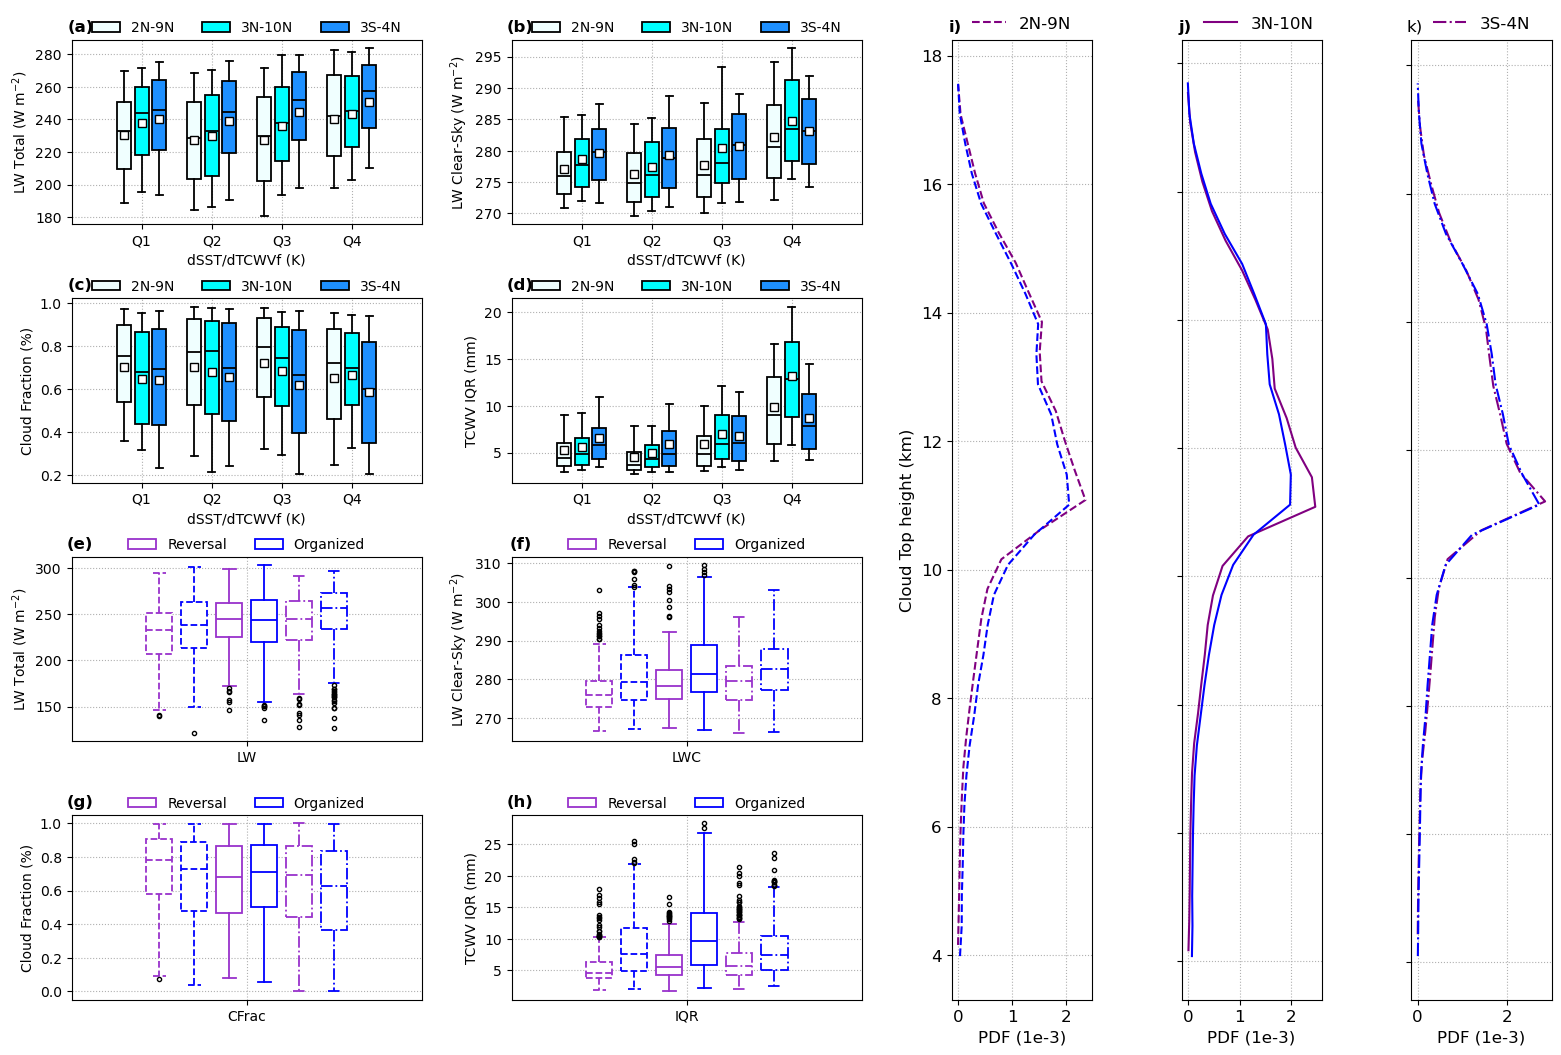

In [13]:
varis = ['LW', 'LWC', 'CTop', 'IQR']
varname = ['LW Total (W m$^{-2}$)','LW Clear-Sky (W m$^{-2}$)', 'Cloud Fraction (%)', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4,5, left=0.05, right=0.975, hspace=0.4, wspace=0.4, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.4,0.4,0.4])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, st2, mt2, ctt2, olr2, pwt2)
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, st3, mt3, ctt3, olr3, pwt3)
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, st3s, mt3s, ctt3s, olr3s, pwt3s)
    quars3s = quart_id(df3s)
    if i < 2:
        ax=subplot(gs[i])
    else:
        ax=subplot(gs[i+3])
    for j,quar in enumerate(quars2):
        pos1,bp1 = box_quart(quar,-sep_to,j,0.2)
        draw_plot(pos1,bp1,-sep_to, "k", "azure", linestyle = '-')
        pos2,bp2 = box_quart(quars3[j],0,j,0.2)
        draw_plot(pos2,bp2,0, "k", "cyan", linestyle = '-')
        pos3,bp3 = box_quart(quars3s[j],sep_to,j,0.2)
        draw_plot(pos3,bp3,sep_to, "k", "dodgerblue", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0],bp3["boxes"][0]], ['2N-9N','3N-10N','3S-4N'], 
               bbox_to_anchor = (0.5,1.17), loc = 'upper center', ncol = 3, 
               frameon = False, fontsize = 10)
    plt.xticks(np.arange(0,4), ['Q1','Q2','Q3','Q4'])
    plt.xlim(-1,4)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')

## '2-9'    
varis2 = [mlo2[mt2.columns[4:5]], mlo2[mt2.columns[3:4]], 
          ctlo2[ctt2.columns[0:]], mlo2[mt2.columns[0:1]]]
var_hi2 = [mhi2[mt2.columns[4:5]], mhi2[mt2.columns[3:4]], 
           cthi2[ctt2.columns[0:]], mhi2[mt2.columns[0:1]]]
## '3-10'
var_lo3 = [mlo3[mt3.columns[4:5]], mlo3[mt3.columns[3:4]], 
           ctlo3[ctt3.columns[0:]], mlo3[mt3.columns[0:1]]]
var_hi3 = [mhi3[mt3.columns[4:5]], mhi3[mt3.columns[3:4]], 
           cthi3[ctt3.columns[0:]], mhi3[mt3.columns[0:1]]]
## '3S-4N'
var_lo3s = [mlo3s[mt3s.columns[4:5]], mlo3s[mt3s.columns[3:4]], 
           ctlo3s[ctt3s.columns[0:]], mlo3s[mt3s.columns[0:1]]]
var_hi3s = [mhi3s[mt3s.columns[4:5]], mhi3s[mt3s.columns[3:4]], 
           cthi3s[ctt3s.columns[0:]], mhi3s[mt3s.columns[0:1]]]

units = ['LW Total (W m$^{-2}$)','LW Clear-Sky (W m$^{-2}$)', 'Cloud Fraction (%)', 'TCWV IQR (mm)']
xtick = [['LW'],['LWC'],['CFrac'],['IQR']]
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    if i < 2:
        ax=subplot(gs[i+10])
    else:
        ax=subplot(gs[i+13])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
    
ax=subplot(gs[0:4,2])
plt.plot(pdf_lo_ct2*1e3, bin_edges_lo_ct2[1:]/100, color = 'purple', label = '2N-9N', linestyle = '--')
plt.plot(pdf_hi_ct2*1e3, bin_edges_hi_ct2[1:]/100, color = 'blue', linestyle = '--')
plt.ylabel('Cloud Top height (km)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.grid(linestyle = ':')
plt.title('i)', x = 0.025, fontweight = 'bold')
plt.xlabel('PDF (1e-3)', fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.5,1.04))

ax=subplot(gs[0:4,3])
plt.plot(pdf_lo_ct3*1e3, bin_edges_lo_ct3[1:]/100, color = 'purple', label = '3N-10N', linestyle = '-')
plt.plot(pdf_hi_ct3*1e3, bin_edges_hi_ct3[1:]/100, color = 'blue', linestyle = '-')
plt.xticks(fontsize = 12)
plt.grid(linestyle = ':')
ax.yaxis.set_major_formatter(NullFormatter())
plt.title('j)', x = 0.025, fontweight = 'bold')
plt.xlabel('PDF (1e-3)', fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.55,1.04))

ax=subplot(gs[0:4,4])
plt.plot(pdf_lo_ct3s*1e3, bin_edges_lo_ct3s[1:]/100, color = 'purple', label = '3S-4N', linestyle = '-.')
plt.plot(pdf_hi_ct3s*1e3, bin_edges_hi_ct3s[1:]/100, color = 'blue', linestyle = '-.')
plt.xticks(fontsize = 12)
plt.grid(linestyle = ':')
ax.yaxis.set_major_formatter(NullFormatter())
plt.title('k)', x = 0.025)
plt.xlabel('PDF (1e-3)', fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.5,1.04))
plt.savefig(path+'Fig_OLR_moist_three_zones_TOP.pdf', bbox_inches='tight', dpi=300)

plt.show()


### Cloud properties with height

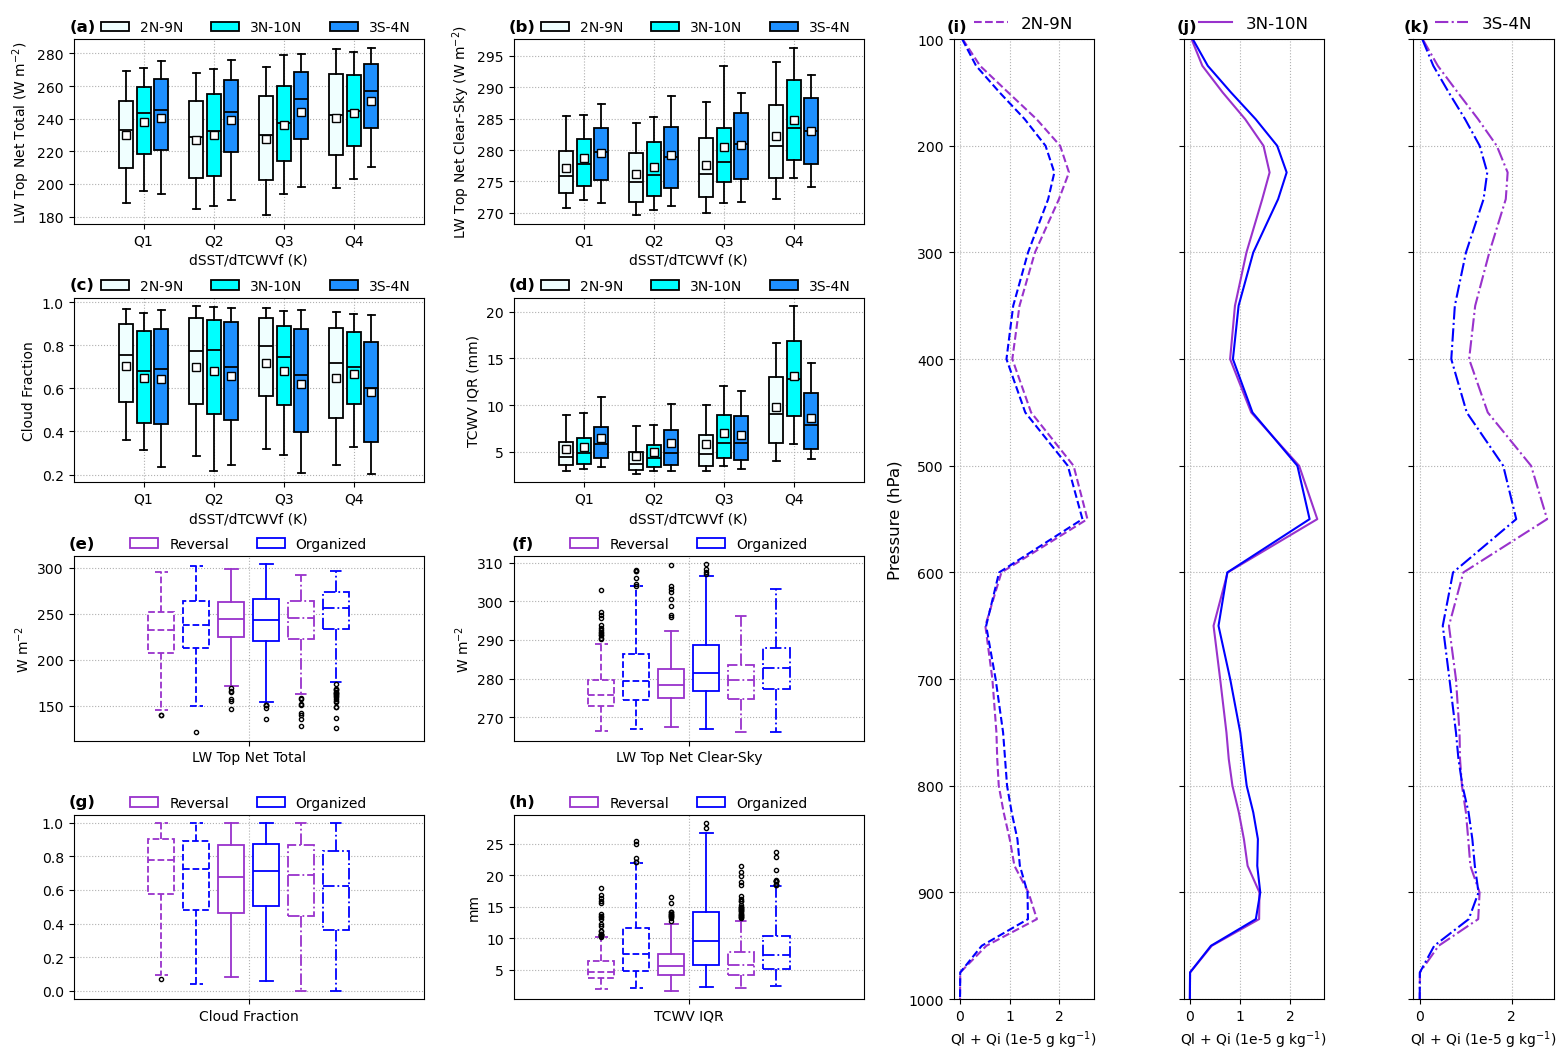

In [14]:
varis = ['LW', 'LWC', 'CTop', 'IQR']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4,5, left=0.05, right=0.975, hspace=0.4, wspace=0.4, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.4,0.4,0.4])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, st2, mt2, ctt2, olr2, pwt2)
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, st3, mt3, ctt3, olr3, pwt3)
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, st3s, mt3s, ctt3s, olr3s, pwt3s)
    quars3s = quart_id(df3s)
    if i < 2:
        ax=subplot(gs[i])
    else:
        ax=subplot(gs[i+3])
    for j,quar in enumerate(quars2):
        pos1,bp1 = box_quart(quar,-sep_to,j,0.2)
        draw_plot(pos1,bp1,-sep_to, "k", "azure", linestyle = '-')
        pos2,bp2 = box_quart(quars3[j],0,j,0.2)
        draw_plot(pos2,bp2,0, "k", "cyan", linestyle = '-')
        pos3,bp3 = box_quart(quars3s[j],sep_to,j,0.2)
        draw_plot(pos3,bp3,sep_to, "k", "dodgerblue", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0],bp3["boxes"][0]], ['2N-9N','3N-10N','3S-4N'], 
               bbox_to_anchor = (0.52,1.17), loc = 'upper center', ncol = 3, 
               frameon = False, fontsize = 10)
    plt.xticks(np.arange(0,4), ['Q1','Q2','Q3','Q4'])
    plt.xlim(-1,4)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')

## '2-9'    
varis2 = [mlo2[mt2.columns[4:5]], mlo2[mt2.columns[3:4]], 
          ctlo2[ctt2.columns[0:]], mlo2[mt2.columns[0:1]]]
var_hi2 = [mhi2[mt2.columns[4:5]], mhi2[mt2.columns[3:4]], 
           cthi2[ctt2.columns[0:]], mhi2[mt2.columns[0:1]]]
## '3-10'
var_lo3 = [mlo3[mt3.columns[4:5]], mlo3[mt3.columns[3:4]], 
           ctlo3[ctt3.columns[0:]], mlo3[mt3.columns[0:1]]]
var_hi3 = [mhi3[mt3.columns[4:5]], mhi3[mt3.columns[3:4]], 
           cthi3[ctt3.columns[0:]], mhi3[mt3.columns[0:1]]]
## '3S-4N'
var_lo3s = [mlo3s[mt3s.columns[4:5]], mlo3s[mt3s.columns[3:4]], 
           ctlo3s[ctt3s.columns[0:]], mlo3s[mt3s.columns[0:1]]]
var_hi3s = [mhi3s[mt3s.columns[4:5]], mhi3s[mt3s.columns[3:4]], 
           cthi3s[ctt3s.columns[0:]], mhi3s[mt3s.columns[0:1]]]

units = ['W m$^{-2}$','W m$^{-2}$','', 'mm']
xtick = [['LW Top Net Total'],['LW Top Net Clear-Sky'],['Cloud Fraction'],['TCWV IQR']]
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    if i < 2:
        ax=subplot(gs[i+10])
    else:
        ax=subplot(gs[i+13])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
#var_lo = [(liq_lo2+ice_lo2+rain_lo2)*1e5, (liq_lo3+ice_lo3+rain_lo3)*1e5, (liq_lo3s+ice_lo3s+rain_lo3s)*1e5]
#var_hi = [(liq_hi2+ice_hi2+rain_hi2)*1e5, (liq_hi3+ice_hi3+rain_hi3)*1e5, (liq_hi3s+ice_hi3s+rain_hi3s)*1e5]
#xlabel = ['Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)']
var_lo = [(liq_lo2+ice_lo2)*1e5, (liq_lo3+ice_lo3)*1e5, (liq_lo3s+ice_lo3s)*1e5]
var_hi = [(liq_hi2+ice_hi2)*1e5, (liq_hi3+ice_hi3)*1e5, (liq_hi3s+ice_hi3s)*1e5]
xlabel = ['Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)']
linestyle = ['--','-','-.']
label = ['2N-9N','3N-10N','3S-4N']
title = ['(i)','(j)','(k)']

for i,var in enumerate(var_lo):
    ax=subplot(gs[0:4,i+2])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = label[i])
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i])
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 10)
    plt.grid(linestyle =':')
    plt.title(title[i], x = 0.025, fontweight = 'bold')
    plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.5,1.04))
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig(path+'Fig_OLR_moist_three_zones_cld_Liq.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Same as above but depending on areas! not quartiles

### For all the period, here we do not separate between seasons

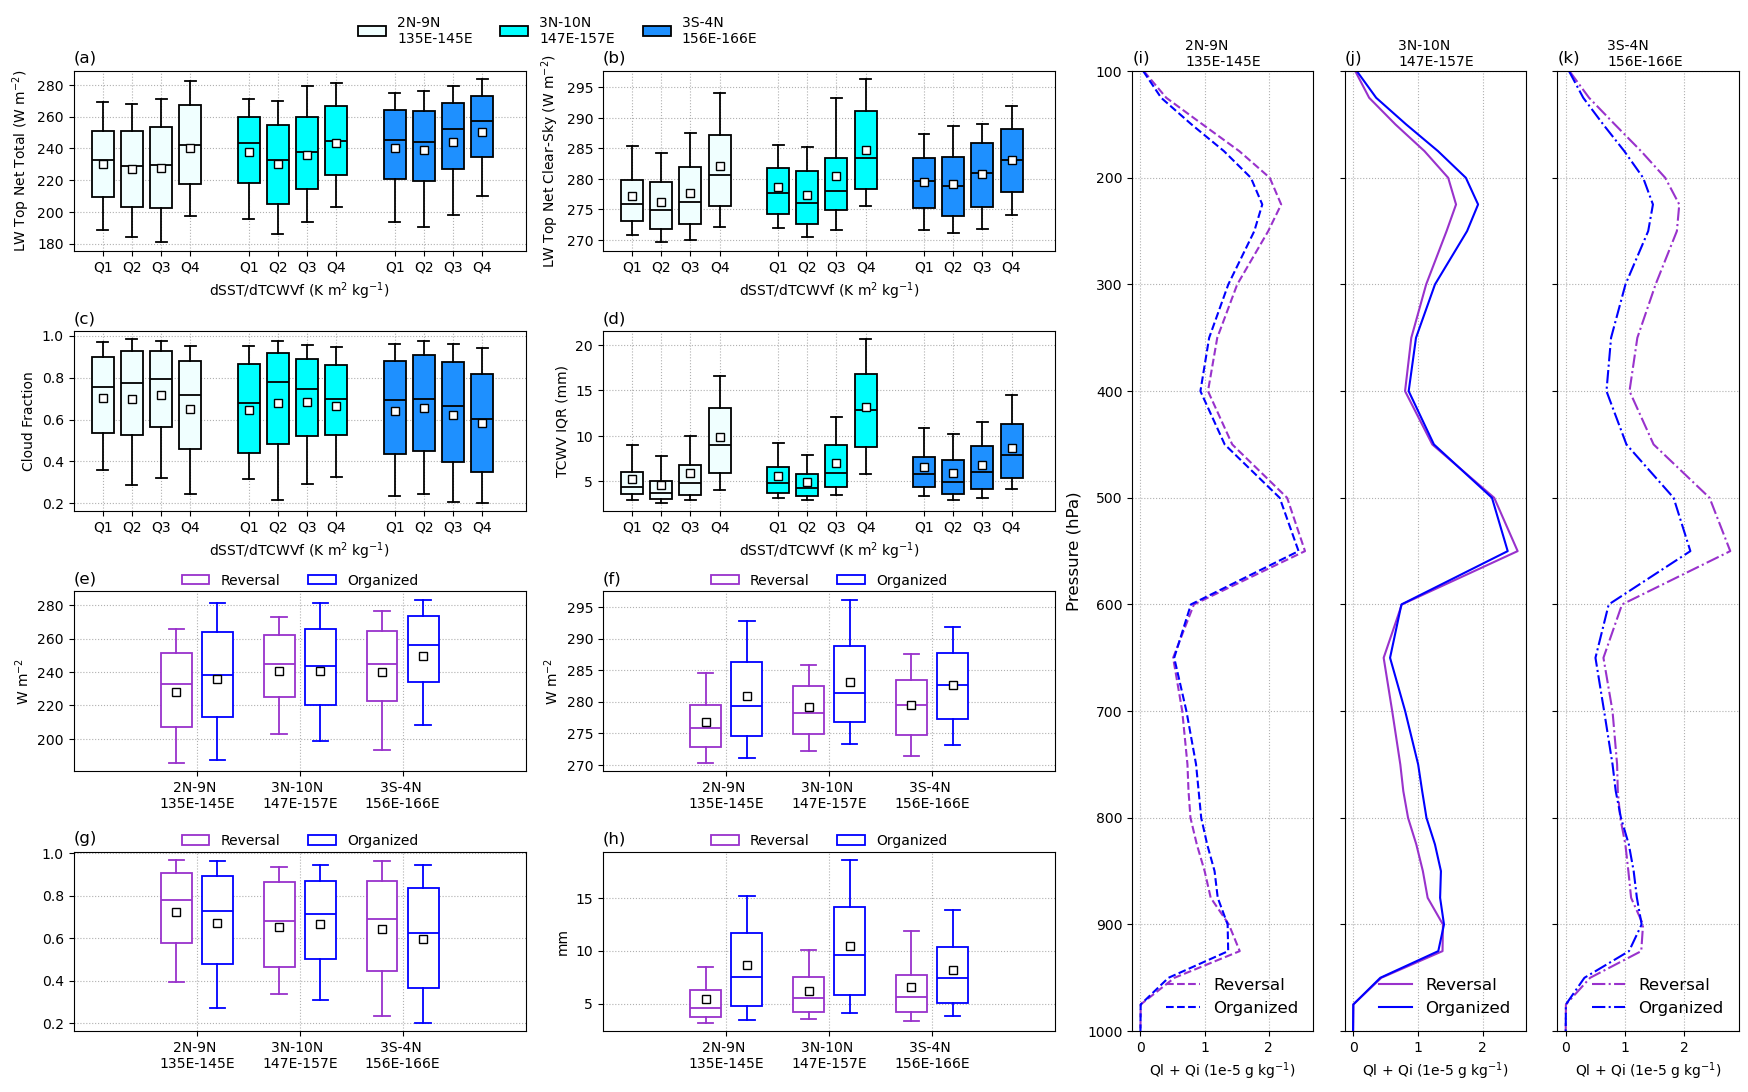

In [15]:
varis = ['LW', 'LWC', 'CTop', 'IQR']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]

fig = plt.figure(figsize=(18,12))
gs = gridspec.GridSpec(4,7, left=0.05, right=0.975, hspace=0.45, wspace=0.15, top=0.9, bottom=0.1, 
                       width_ratios=[1,0.03,1,0.03,0.4,0.4,0.4])
sep_to = 0.25
pos = [0,2,7,9]

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, st2, mt2, ctt2, olr2, pwt2)
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, st3, mt3, ctt3, olr3, pwt3)
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, st3s, mt3s, ctt3s, olr3s, pwt3s)
    quars3s = quart_id(df3s)
    ax=subplot(gs[pos[i]])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    if i == 0:
        ax.legend([bps[0],bps[1],bps[2]], ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E'], 
                  bbox_to_anchor = (1.07,1.38), loc = 'upper center', ncol = 3, 
                  frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K m$^{2}$ kg$^{-1}$)')
    plt.grid(linestyle = ':')
    plt.title(title[i], loc='left')
    
## '2-9'    
varis2 = [mlo2[mt2.columns[4:5]], mlo2[mt2.columns[3:4]], 
          ctlo2[ctt2.columns[0:]], mlo2[mt2.columns[0:1]]]
var_hi2 = [mhi2[mt2.columns[4:5]], mhi2[mt2.columns[3:4]], 
           cthi2[ctt2.columns[0:]], mhi2[mt2.columns[0:1]]]
## '3-10'
var_lo3 = [mlo3[mt3.columns[4:5]], mlo3[mt3.columns[3:4]], 
           ctlo3[ctt3.columns[0:]], mlo3[mt3.columns[0:1]]]
var_hi3 = [mhi3[mt3.columns[4:5]], mhi3[mt3.columns[3:4]], 
           cthi3[ctt3.columns[0:]], mhi3[mt3.columns[0:1]]]
## '3S-4N'
var_lo3s = [mlo3s[mt3s.columns[4:5]], mlo3s[mt3s.columns[3:4]], 
           ctlo3s[ctt3s.columns[0:]], mlo3s[mt3s.columns[0:1]]]
var_hi3s = [mhi3s[mt3s.columns[4:5]], mhi3s[mt3s.columns[3:4]], 
           cthi3s[ctt3s.columns[0:]], mhi3s[mt3s.columns[0:1]]]

units = ['W m$^{-2}$','W m$^{-2}$','', 'mm']
xtick = [['LW Top Net Total'],['LW Top Net Clear-Sky'],['Cloud Fraction'],['TCWV IQR']]
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
posi = [14,16,21,23]
for i,var in enumerate(varis2):
    ax=subplot(gs[posi[i]])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.6)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, showmeans=True, 
                     whis=[10,90], showfliers=False,
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.4)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, showmeans=True, 
                     whis=[10,90], showfliers=False,
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '-')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width,  showmeans=True, 
                     whis=[10,90], showfliers=False,
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width,  showmeans=True, 
                     whis=[10,90], showfliers=False,
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.4)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, showmeans=True,
                     whis=[10,90], showfliers=False,
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.6)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width,  showmeans=True, 
                     whis=[10,90], showfliers=False,
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    #ax.set_xticks(pos, xtick[i])
    plt.xticks([-0.5,0.0,0.5], ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E'],fontsize = 10)
    ax.set_ylabel(units[i],fontsize = 10)
    plt.grid(linestyle = ':')
    plt.title(title[i], loc='left')
    
#var_lo = [(liq_lo2+ice_lo2+rain_lo2)*1e5, (liq_lo3+ice_lo3+rain_lo3)*1e5, (liq_lo3s+ice_lo3s+rain_lo3s)*1e5]
#var_hi = [(liq_hi2+ice_hi2+rain_hi2)*1e5, (liq_hi3+ice_hi3+rain_hi3)*1e5, (liq_hi3s+ice_hi3s+rain_hi3s)*1e5]
#xlabel = ['Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)']
var_lo = [(liq_lo2+ice_lo2)*1e5, (liq_lo3+ice_lo3)*1e5, (liq_lo3s+ice_lo3s)*1e5]
var_hi = [(liq_hi2+ice_hi2)*1e5, (liq_hi3+ice_hi3)*1e5, (liq_hi3s+ice_hi3s)*1e5]
xlabel = ['Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)']
linestyle = ['--','-','-.']
label = ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E']
title = ['(i)','(j)','(k)']

for i,var in enumerate(var_lo):
    ax=subplot(gs[0:4,i+4])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = 'Reversal')
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i], label = 'Organized')
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 10)
    plt.grid(linestyle =':')
    plt.text(0.7,95,label[i], fontsize=10)
    plt.title(title[i], loc='left')
    plt.legend(frameon = False, fontsize = 12, loc = 'lower right')
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq.jpg', bbox_inches='tight', dpi=300)

plt.show()

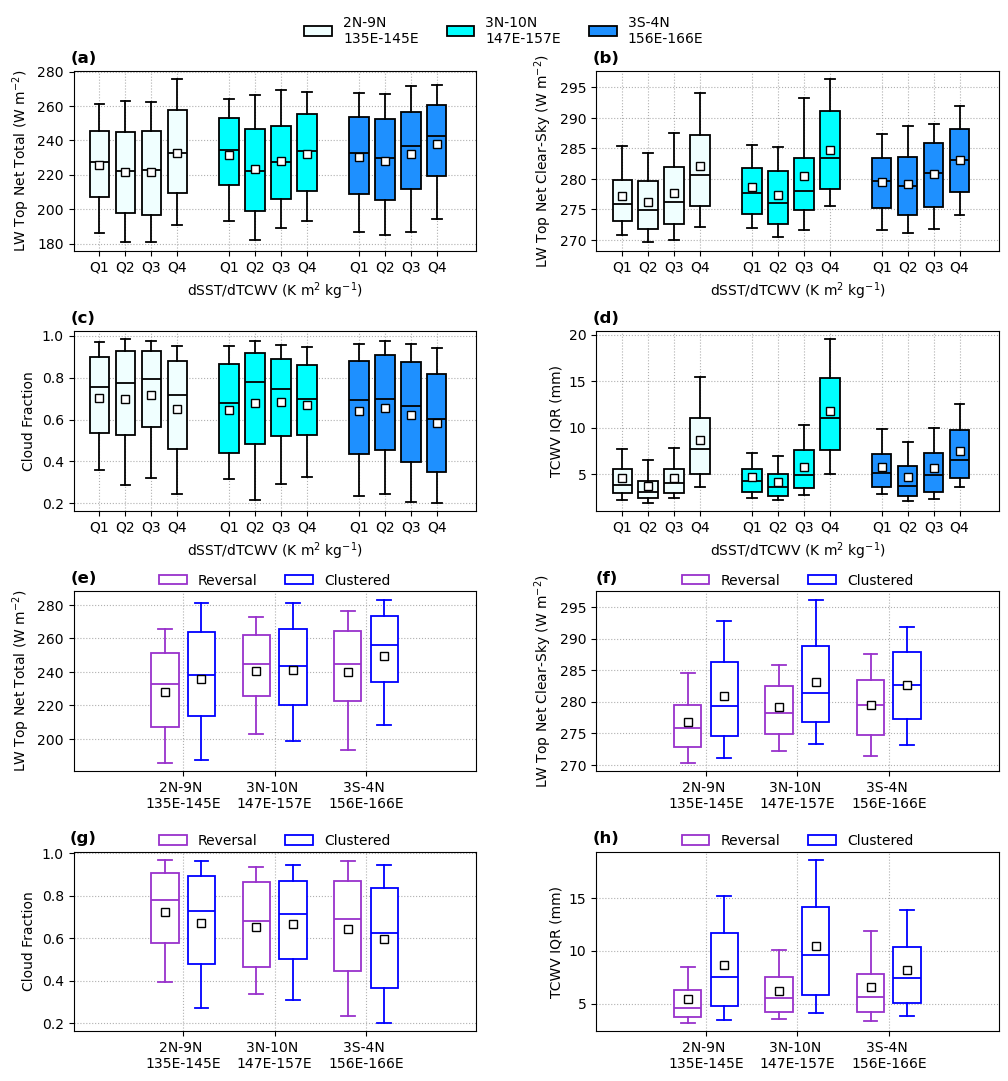

In [16]:
varis = ['OLR', 'LWC', 'CTop', 'IQR_pw']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]

fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(4,2, left=0.05, right=0.975, hspace=0.45, wspace=0.3, top=0.9, bottom=0.1, 
                       width_ratios=[1,1])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, st2, mt2, ctt2, olr2, pwt2)
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, st3, mt3, ctt3, olr3, pwt3)
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, st3s, mt3s, ctt3s, olr3s, pwt3s)
    quars3s = quart_id(df3s)
    ax=subplot(gs[i])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    if i == 0:
        ax.legend([bps[0],bps[1],bps[2]], ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E'], 
                  bbox_to_anchor = (1.07,1.38), loc = 'upper center', ncol = 3, 
                  frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWV (K m$^{2}$ kg$^{-1}$)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
## '2-9'    
varis2 = [mlo2[mt2.columns[4:5]], mlo2[mt2.columns[3:4]], 
          ctlo2[ctt2.columns[0:]], mlo2[mt2.columns[0:1]]]
var_hi2 = [mhi2[mt2.columns[4:5]], mhi2[mt2.columns[3:4]], 
           cthi2[ctt2.columns[0:]], mhi2[mt2.columns[0:1]]]
## '3-10'
var_lo3 = [mlo3[mt3.columns[4:5]], mlo3[mt3.columns[3:4]], 
           ctlo3[ctt3.columns[0:]], mlo3[mt3.columns[0:1]]]
var_hi3 = [mhi3[mt3.columns[4:5]], mhi3[mt3.columns[3:4]], 
           cthi3[ctt3.columns[0:]], mhi3[mt3.columns[0:1]]]
## '3S-4N'
var_lo3s = [mlo3s[mt3s.columns[4:5]], mlo3s[mt3s.columns[3:4]], 
           ctlo3s[ctt3s.columns[0:]], mlo3s[mt3s.columns[0:1]]]
var_hi3s = [mhi3s[mt3s.columns[4:5]], mhi3s[mt3s.columns[3:4]], 
           cthi3s[ctt3s.columns[0:]], mhi3s[mt3s.columns[0:1]]]

units = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)','Cloud Fraction', 'TCWV IQR (mm)']
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    ax=subplot(gs[i+4])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.6)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, showmeans=True, showfliers=False, whis=[10,90],
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.4)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, showmeans=True, showfliers=False, whis=[10,90],
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '-')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, showmeans=True, showfliers=False, whis=[10,90],
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, showmeans=True, showfliers=False, whis=[10,90],
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Clustered'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.4)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, showmeans=True,showfliers=False, whis=[10,90],
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.6)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, showmeans=True,showfliers=False, whis=[10,90],
                     meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    #ax.set_xticks(pos, xtick[i])
    plt.xticks([-0.5,0.0,0.5], ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E'],fontsize = 10)
    ax.set_ylabel(units[i],fontsize = 10)
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_Satellite.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_Satellite.jpg', bbox_inches='tight', dpi=300)
plt.show()

# With satellite

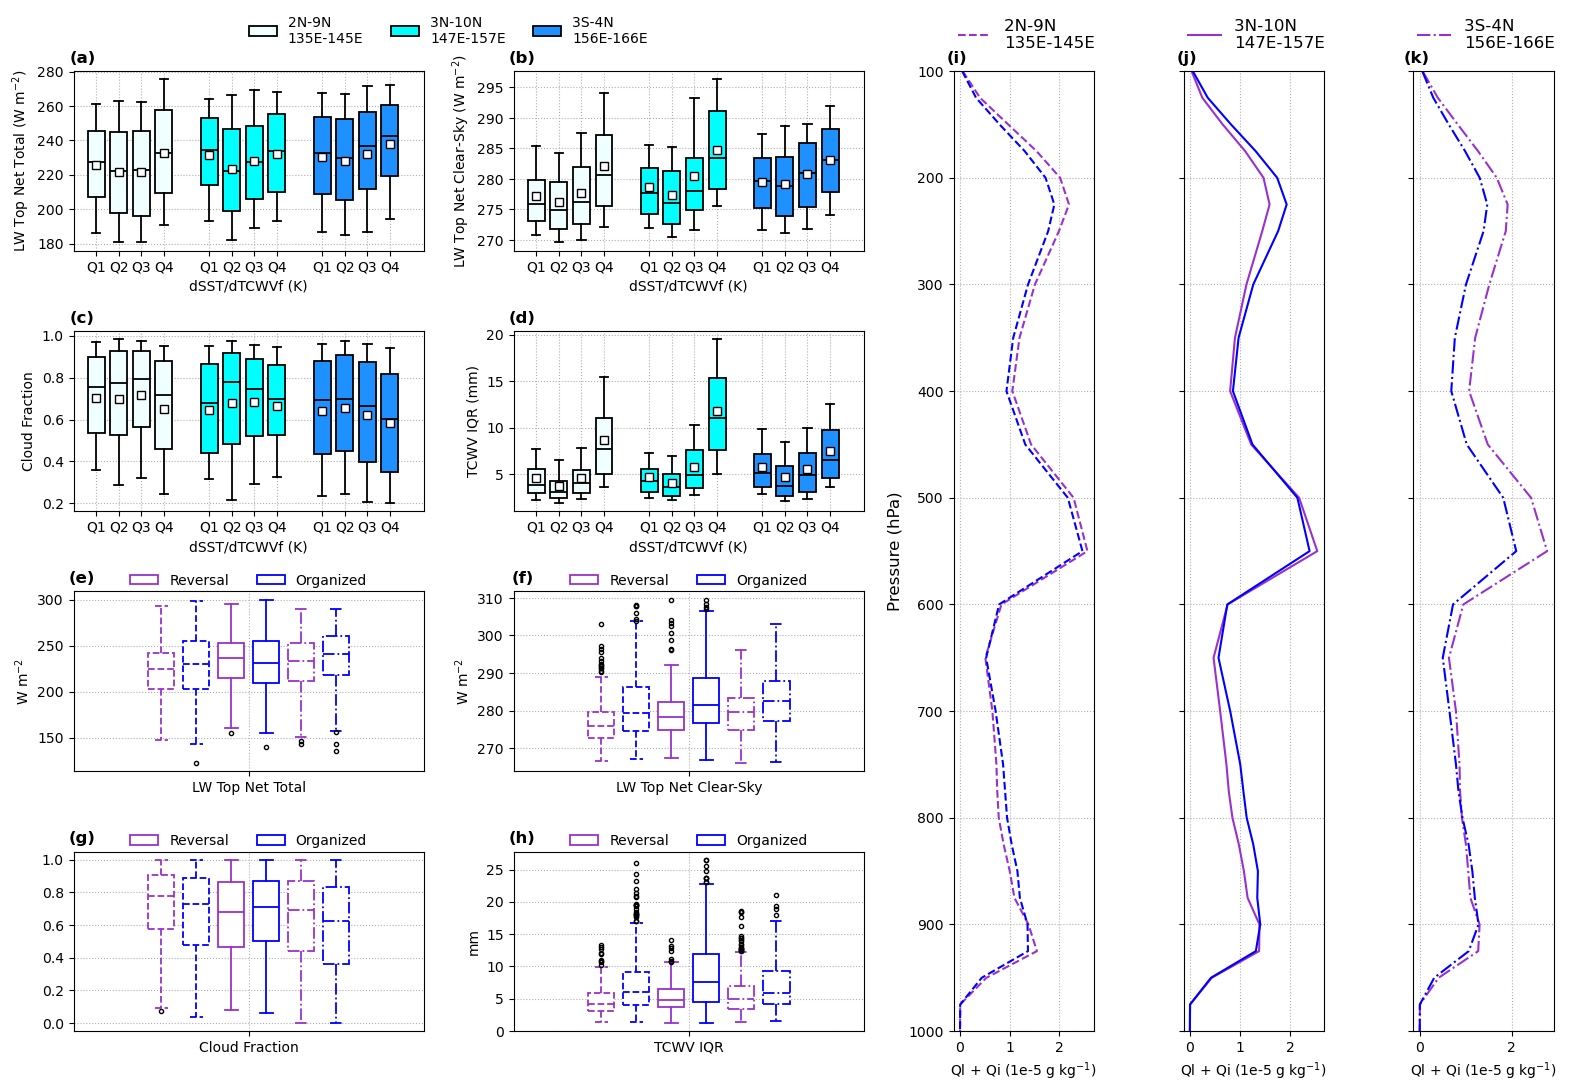

In [17]:
varis = ['OLR', 'LWC', 'CTop', 'IQR_pw']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4,5, left=0.05, right=0.975, hspace=0.45, wspace=0.4, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.4,0.4,0.4])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, st2, mt2, ctt2, olr2, pwt2)
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, st3, mt3, ctt3, olr3, pwt3)
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, st3s, mt3s, ctt3s, olr3s, pwt3s)
    quars3s = quart_id(df3s)
    if i < 2:
        ax=subplot(gs[i])
    else:
        ax=subplot(gs[i+3])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    if i == 0:
        ax.legend([bps[0],bps[1],bps[2]], ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E'], 
                  bbox_to_anchor = (1.07,1.38), loc = 'upper center', ncol = 3, 
                  frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
## '2-9'    
varis2 = [olrlo2[olrlo2.columns[0:]], mlo2[mt2.columns[3:4]], 
          ctlo2[ctt2.columns[0:]], pwlo2[pwlo2.columns[0:]]]
var_hi2 = [olrhi2[olrhi2.columns[0:]], mhi2[mt2.columns[3:4]], 
           cthi2[ctt2.columns[0:]], pwhi2[pwhi2.columns[0:]]]
## '3-10'
var_lo3 = [olrlo3[olrlo3.columns[0:]], mlo3[mt3.columns[3:4]], 
           ctlo3[ctt3.columns[0:]], pwlo3[pwlo3.columns[0:]]]
var_hi3 = [olrhi3[olrhi3.columns[0:]], mhi3[mt3.columns[3:4]], 
           cthi3[ctt3.columns[0:]], pwhi3[pwhi3.columns[0:]]]
## '3S-4N'
var_lo3s = [olrlo3s[olrlo3s.columns[0:]], mlo3s[mt3s.columns[3:4]], 
            ctlo3s[ctt3s.columns[0:]], pwlo3s[pwlo3s.columns[0:]]]
var_hi3s = [olrhi3s[olrhi3s.columns[0:]], mhi3s[mt3s.columns[3:4]], 
            cthi3s[ctt3s.columns[0:]], pwhi3s[pwhi3s.columns[0:]]]

units = ['W m$^{-2}$','W m$^{-2}$','', 'mm']
xtick = [['LW Top Net Total'],['LW Top Net Clear-Sky'],['Cloud Fraction'],['TCWV IQR']]
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    if i < 2:
        ax=subplot(gs[i+10])
    else:
        ax=subplot(gs[i+13])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
#var_lo = [(liq_lo2+ice_lo2+rain_lo2)*1e5, (liq_lo3+ice_lo3+rain_lo3)*1e5, (liq_lo3s+ice_lo3s+rain_lo3s)*1e5]
#var_hi = [(liq_hi2+ice_hi2+rain_hi2)*1e5, (liq_hi3+ice_hi3+rain_hi3)*1e5, (liq_hi3s+ice_hi3s+rain_hi3s)*1e5]
#xlabel = ['Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)']
var_lo = [(liq_lo2+ice_lo2)*1e5, (liq_lo3+ice_lo3)*1e5, (liq_lo3s+ice_lo3s)*1e5]
var_hi = [(liq_hi2+ice_hi2)*1e5, (liq_hi3+ice_hi3)*1e5, (liq_hi3s+ice_hi3s)*1e5]
xlabel = ['Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)']
linestyle = ['--','-','-.']
label = ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E']
title = ['(i)','(j)','(k)']

for i,var in enumerate(var_lo):
    ax=subplot(gs[0:4,i+2])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = label[i])
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i])
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 10)
    plt.grid(linestyle =':')
    plt.title(title[i], x = 0.025, fontweight = 'bold')
    plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.52,1.07))
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_Satellite.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_Satellite.jpg', bbox_inches='tight', dpi=300)
plt.show()

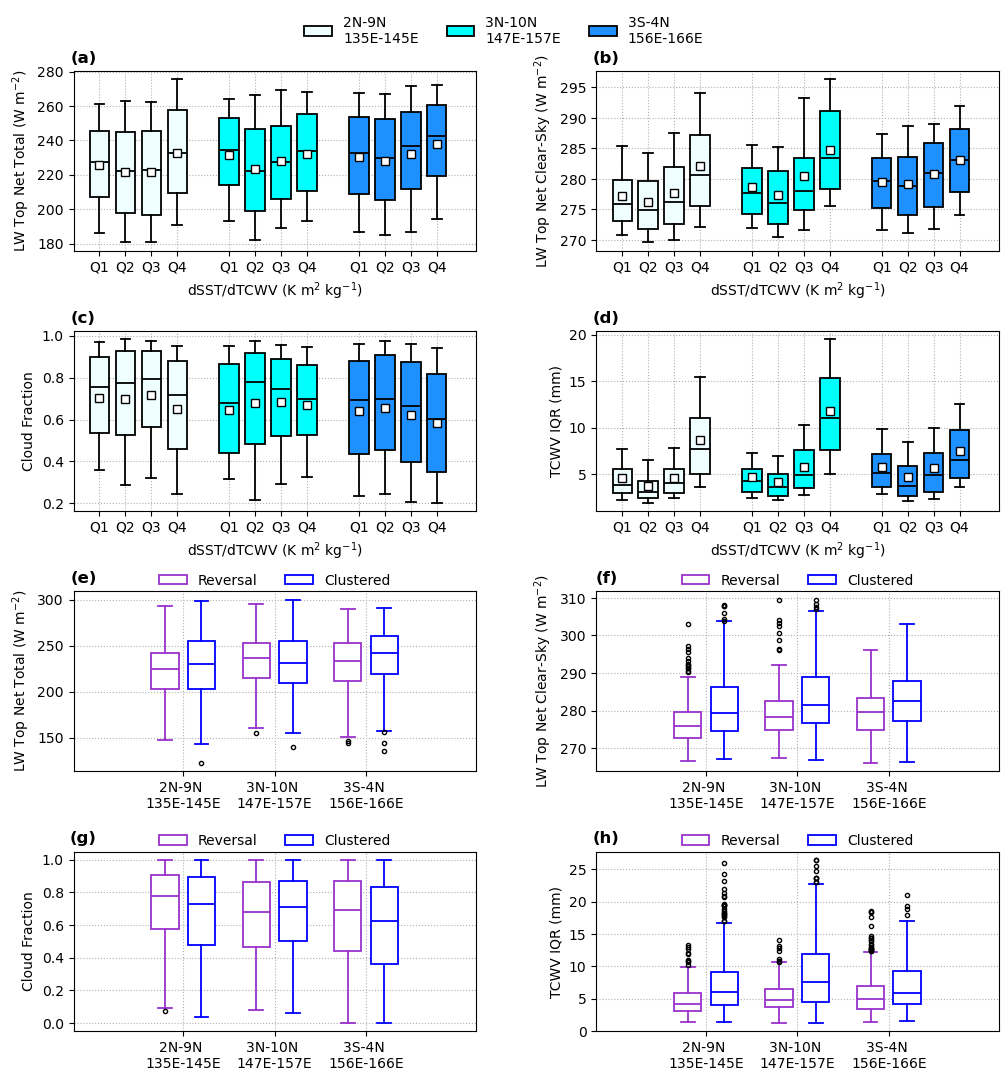

In [25]:
varis = ['OLR', 'LWC', 'CTop', 'IQR_pw']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]

fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(4,2, left=0.05, right=0.975, hspace=0.45, wspace=0.3, top=0.9, bottom=0.1, 
                       width_ratios=[1,1])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, st2, mt2, ctt2, olr2, pwt2)
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, st3, mt3, ctt3, olr3, pwt3)
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, st3s, mt3s, ctt3s, olr3s, pwt3s)
    quars3s = quart_id(df3s)
    ax=subplot(gs[i])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    if i == 0:
        ax.legend([bps[0],bps[1],bps[2]], ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E'], 
                  bbox_to_anchor = (1.07,1.38), loc = 'upper center', ncol = 3, 
                  frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWV (K m$^2$ kg$^{-1}$)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
## '2-9'    
varis2 = [olrlo2[olrlo2.columns[0:]], mlo2[mt2.columns[3:4]], 
          ctlo2[ctt2.columns[0:]], pwlo2[pwlo2.columns[0:]]]
var_hi2 = [olrhi2[olrhi2.columns[0:]], mhi2[mt2.columns[3:4]], 
           cthi2[ctt2.columns[0:]], pwhi2[pwhi2.columns[0:]]]
## '3-10'
var_lo3 = [olrlo3[olrlo3.columns[0:]], mlo3[mt3.columns[3:4]], 
           ctlo3[ctt3.columns[0:]], pwlo3[pwlo3.columns[0:]]]
var_hi3 = [olrhi3[olrhi3.columns[0:]], mhi3[mt3.columns[3:4]], 
           cthi3[ctt3.columns[0:]], pwhi3[pwhi3.columns[0:]]]
## '3S-4N'
var_lo3s = [olrlo3s[olrlo3s.columns[0:]], mlo3s[mt3s.columns[3:4]], 
            ctlo3s[ctt3s.columns[0:]], pwlo3s[pwlo3s.columns[0:]]]
var_hi3s = [olrhi3s[olrhi3s.columns[0:]], mhi3s[mt3s.columns[3:4]], 
            cthi3s[ctt3s.columns[0:]], pwhi3s[pwhi3s.columns[0:]]]

units = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)','Cloud Fraction', 'TCWV IQR (mm)']
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    ax=subplot(gs[i+4])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.6)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.4)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '-')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Clustered'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.4)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.6)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    #ax.set_xticks(pos, xtick[i])
    plt.xticks([-0.5,0.0,0.5], ['2N-9N \n135E-145E','3N-10N \n147E-157E','3S-4N \n156E-166E'],fontsize = 10)
    ax.set_ylabel(units[i],fontsize = 10)
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_Satellite.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_Satellite.jpg', bbox_inches='tight', dpi=300)
plt.show()

# Lets separate them by seasons

In [19]:
def scatter_box1(var, varname, nbin, slope, met_all, ctt):
    df1 = pd.DataFrame(data = {'Slope': slope['Slope']*100})
    df1['bins'] = pd.qcut(df1['Slope'], nbin, precision = 4)
    if var == 'CTop':
        df = pd.DataFrame(data = {varname: ctt[var]})
    else:
        df = pd.DataFrame(data = {varname: met_all[var]})

    df = df.melt(value_vars=[varname],
                 var_name='Conditions', value_name='Value', ignore_index=False)
    df['bins'] = df1['bins']
    del(df1)
    return(df)

### DJF

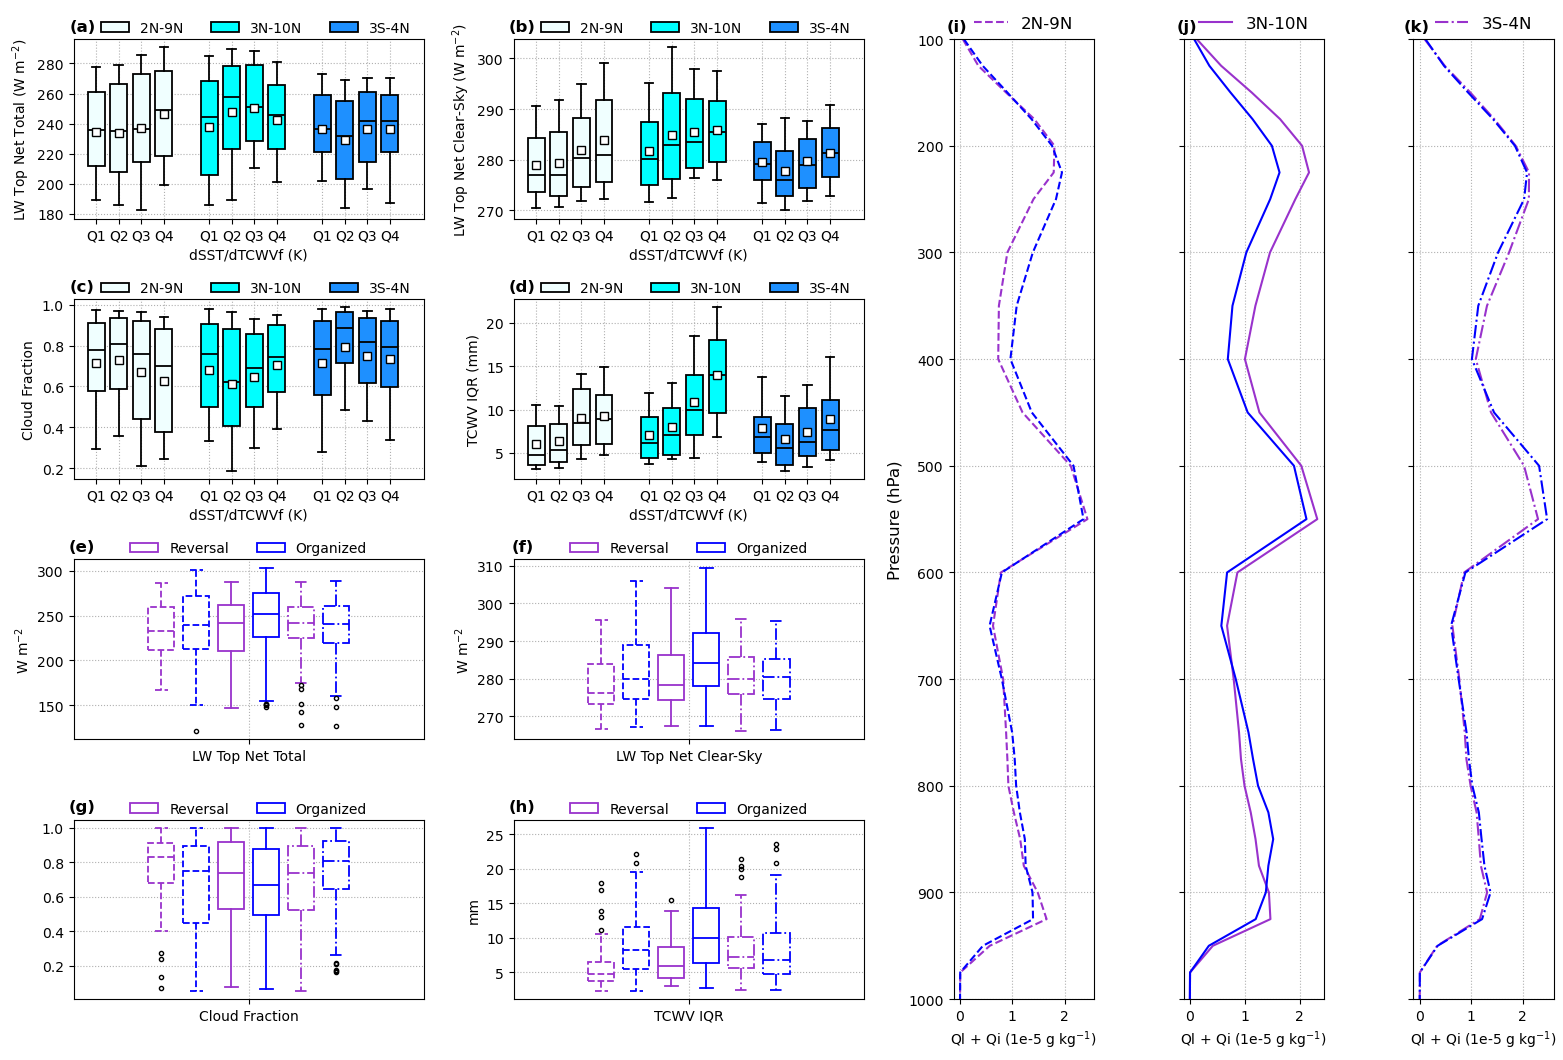

In [20]:
varis = ['LW', 'LWC', 'CTop', 'IQR']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]
season = 'DJF'

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4,5, left=0.05, right=0.975, hspace=0.45, wspace=0.4, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.4,0.4,0.4])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box1(var, varname[i], 4, tot_slo_season['st2_'+season], 
                      tot_slo_season['mt2_'+season], tot_slo_season['ctt2_'+season])
    quars2 = quart_id(df2)
    df3 = scatter_box1(var, varname[i], 4, tot_slo_season['st3_'+season], 
                      tot_slo_season['mt3_'+season], tot_slo_season['ctt3_'+season])
    quars3 = quart_id(df3)
    df3s = scatter_box1(var, varname[i], 4, tot_slo_season['st3s_'+season], 
                      tot_slo_season['mt3s_'+season], tot_slo_season['ctt3s_'+season])
    quars3s = quart_id(df3s)
    if i < 2:
        ax=subplot(gs[i])
    else:
        ax=subplot(gs[i+3])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    ax.legend([bps[0],bps[1],bps[2]], ['2N-9N','3N-10N','3S-4N'], 
              bbox_to_anchor = (0.52,1.17), loc = 'upper center', ncol = 3, 
              frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
## '2-9'    
varis2 = [data_season['mlo2_'+season][mt2.columns[4:5]], data_season['mlo2_'+season][mt2.columns[3:4]], 
          data_season['ctlo2_'+season][ctt2.columns[0:]], data_season['mlo2_'+season][mt2.columns[0:1]]]
var_hi2 = [data_season['mhi2_'+season][mt2.columns[4:5]], data_season['mhi2_'+season][mt2.columns[3:4]], 
           data_season['cthi2_'+season][ctt2.columns[0:]], data_season['mhi2_'+season][mt2.columns[0:1]]]
## '3-10'
var_lo3 = [data_season['mlo3_'+season][mt2.columns[4:5]], data_season['mlo3_'+season][mt2.columns[3:4]], 
           data_season['ctlo3_'+season][ctt2.columns[0:]], data_season['mlo3_'+season][mt2.columns[0:1]]]
var_hi3 = [data_season['mhi3_'+season][mt2.columns[4:5]], data_season['mhi3_'+season][mt2.columns[3:4]], 
           data_season['cthi3_'+season][ctt2.columns[0:]], data_season['mhi3_'+season][mt2.columns[0:1]]]
## '3S-4N'
var_lo3s = [data_season['mlo3s_'+season][mt2.columns[4:5]], data_season['mlo3s_'+season][mt2.columns[3:4]], 
            data_season['ctlo3s_'+season][ctt2.columns[0:]], data_season['mlo3s_'+season][mt2.columns[0:1]]]
var_hi3s = [data_season['mhi3s_'+season][mt2.columns[4:5]], data_season['mhi3s_'+season][mt2.columns[3:4]], 
            data_season['cthi3s_'+season][ctt2.columns[0:]], data_season['mhi3s_'+season][mt2.columns[0:1]]]

units = ['W m$^{-2}$','W m$^{-2}$','', 'mm']
xtick = [['LW Top Net Total'],['LW Top Net Clear-Sky'],['Cloud Fraction'],['TCWV IQR']]
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    if i < 2:
        ax=subplot(gs[i+10])
    else:
        ax=subplot(gs[i+13])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
#var_lo = [(liq_lo2+ice_lo2+rain_lo2)*1e5, (liq_lo3+ice_lo3+rain_lo3)*1e5, (liq_lo3s+ice_lo3s+rain_lo3s)*1e5]
#var_hi = [(liq_hi2+ice_hi2+rain_hi2)*1e5, (liq_hi3+ice_hi3+rain_hi3)*1e5, (liq_hi3s+ice_hi3s+rain_hi3s)*1e5]
#xlabel = ['Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)']
var_lo = [(cld_season['liq_lo2_'+season]+cld_season['ice_lo2_'+season])*1e5, 
          (cld_season['liq_lo3_'+season]+cld_season['ice_lo3_'+season])*1e5, 
          (cld_season['liq_lo3s_'+season]+cld_season['ice_lo3s_'+season])*1e5]
var_hi = [(cld_season['liq_hi2_'+season]+cld_season['ice_hi2_'+season])*1e5, 
          (cld_season['liq_hi3_'+season]+cld_season['ice_hi3_'+season])*1e5, 
          (cld_season['liq_hi3s_'+season]+cld_season['ice_hi3s_'+season])*1e5]
xlabel = ['Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)']
linestyle = ['--','-','-.']
label = ['2N-9N','3N-10N','3S-4N']
title = ['(i)','(j)','(k)']

for i,var in enumerate(var_lo):
    ax=subplot(gs[0:4,i+2])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = label[i])
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i])
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 10)
    plt.grid(linestyle =':')
    plt.title(title[i], x = 0.025, fontweight = 'bold')
    plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.5,1.04))
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_'+season+'.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_'+season+'.jpg', bbox_inches='tight', dpi=300)
plt.show()

### MAM

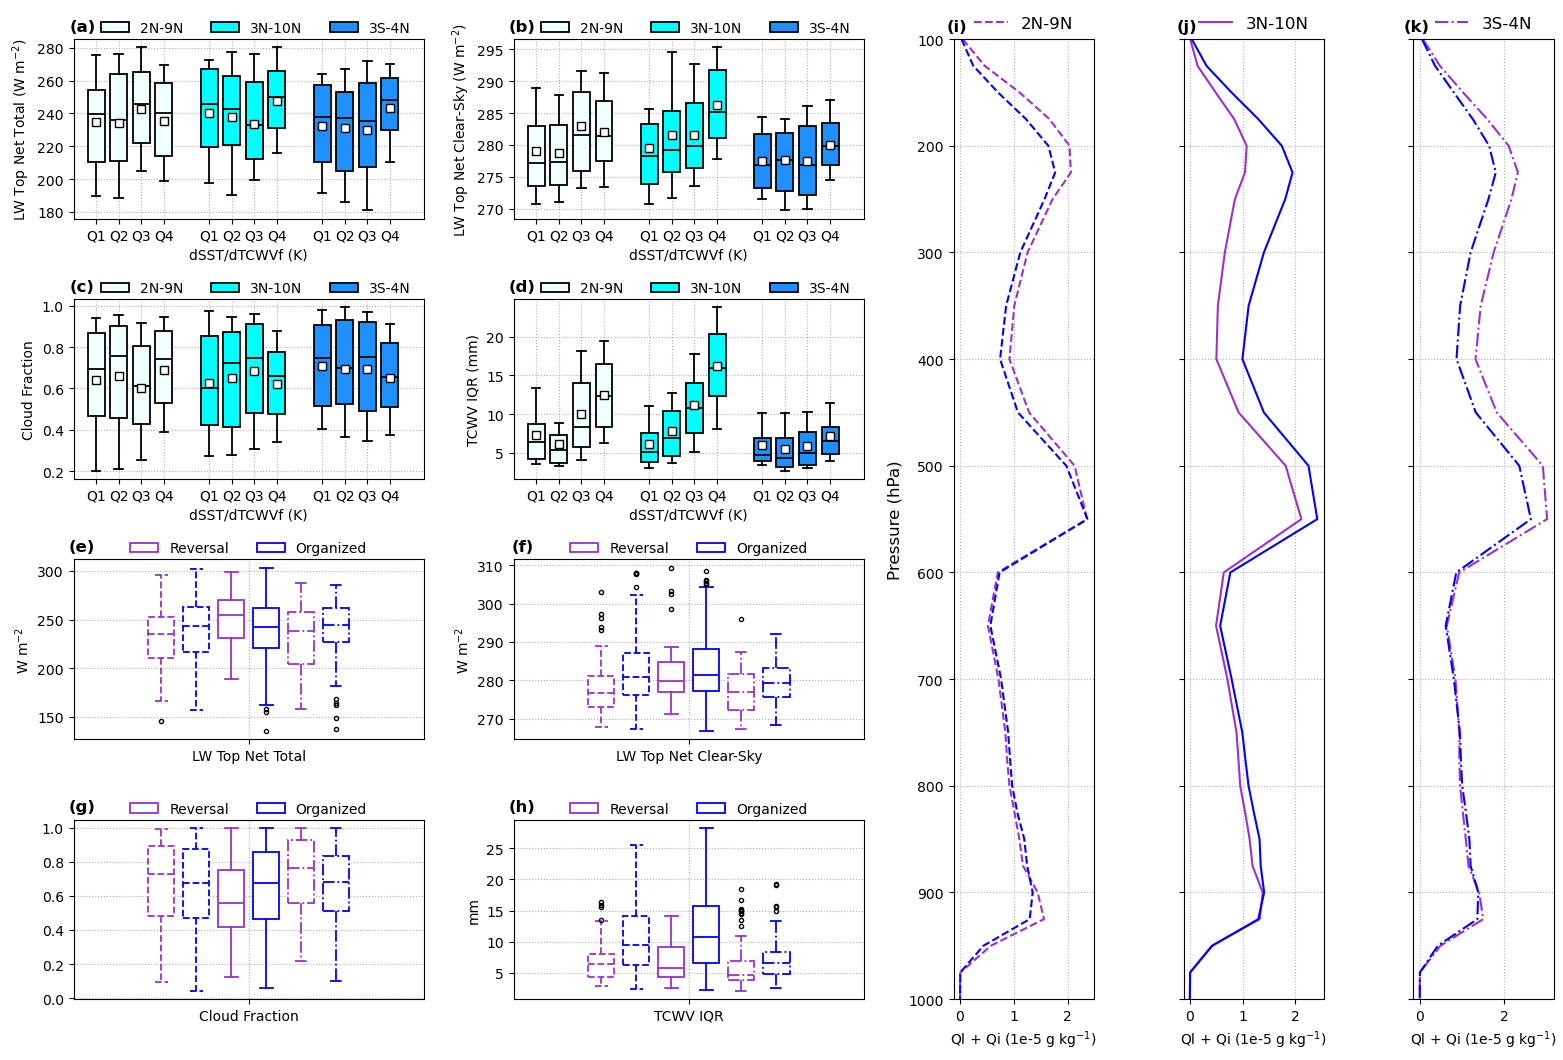

In [21]:
varis = ['LW', 'LWC', 'CTop', 'IQR']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]
season = 'MAM'

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4,5, left=0.05, right=0.975, hspace=0.45, wspace=0.4, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.4,0.4,0.4])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box1(var, varname[i], 4, tot_slo_season['st2_'+season], 
                      tot_slo_season['mt2_'+season], tot_slo_season['ctt2_'+season])
    quars2 = quart_id(df2)
    df3 = scatter_box1(var, varname[i], 4, tot_slo_season['st3_'+season], 
                      tot_slo_season['mt3_'+season], tot_slo_season['ctt3_'+season])
    quars3 = quart_id(df3)
    df3s = scatter_box1(var, varname[i], 4, tot_slo_season['st3s_'+season], 
                      tot_slo_season['mt3s_'+season], tot_slo_season['ctt3s_'+season])
    quars3s = quart_id(df3s)
    if i < 2:
        ax=subplot(gs[i])
    else:
        ax=subplot(gs[i+3])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    ax.legend([bps[0],bps[1],bps[2]], ['2N-9N','3N-10N','3S-4N'], 
              bbox_to_anchor = (0.52,1.17), loc = 'upper center', ncol = 3, 
              frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
## '2-9'    
varis2 = [data_season['mlo2_'+season][mt2.columns[4:5]], data_season['mlo2_'+season][mt2.columns[3:4]], 
          data_season['ctlo2_'+season][ctt2.columns[0:]], data_season['mlo2_'+season][mt2.columns[0:1]]]
var_hi2 = [data_season['mhi2_'+season][mt2.columns[4:5]], data_season['mhi2_'+season][mt2.columns[3:4]], 
           data_season['cthi2_'+season][ctt2.columns[0:]], data_season['mhi2_'+season][mt2.columns[0:1]]]
## '3-10'
var_lo3 = [data_season['mlo3_'+season][mt2.columns[4:5]], data_season['mlo3_'+season][mt2.columns[3:4]], 
           data_season['ctlo3_'+season][ctt2.columns[0:]], data_season['mlo3_'+season][mt2.columns[0:1]]]
var_hi3 = [data_season['mhi3_'+season][mt2.columns[4:5]], data_season['mhi3_'+season][mt2.columns[3:4]], 
           data_season['cthi3_'+season][ctt2.columns[0:]], data_season['mhi3_'+season][mt2.columns[0:1]]]
## '3S-4N'
var_lo3s = [data_season['mlo3s_'+season][mt2.columns[4:5]], data_season['mlo3s_'+season][mt2.columns[3:4]], 
            data_season['ctlo3s_'+season][ctt2.columns[0:]], data_season['mlo3s_'+season][mt2.columns[0:1]]]
var_hi3s = [data_season['mhi3s_'+season][mt2.columns[4:5]], data_season['mhi3s_'+season][mt2.columns[3:4]], 
            data_season['cthi3s_'+season][ctt2.columns[0:]], data_season['mhi3s_'+season][mt2.columns[0:1]]]

units = ['W m$^{-2}$','W m$^{-2}$','', 'mm']
xtick = [['LW Top Net Total'],['LW Top Net Clear-Sky'],['Cloud Fraction'],['TCWV IQR']]
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    if i < 2:
        ax=subplot(gs[i+10])
    else:
        ax=subplot(gs[i+13])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
#var_lo = [(liq_lo2+ice_lo2+rain_lo2)*1e5, (liq_lo3+ice_lo3+rain_lo3)*1e5, (liq_lo3s+ice_lo3s+rain_lo3s)*1e5]
#var_hi = [(liq_hi2+ice_hi2+rain_hi2)*1e5, (liq_hi3+ice_hi3+rain_hi3)*1e5, (liq_hi3s+ice_hi3s+rain_hi3s)*1e5]
#xlabel = ['Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)']
var_lo = [(cld_season['liq_lo2_'+season]+cld_season['ice_lo2_'+season])*1e5, 
          (cld_season['liq_lo3_'+season]+cld_season['ice_lo3_'+season])*1e5, 
          (cld_season['liq_lo3s_'+season]+cld_season['ice_lo3s_'+season])*1e5]
var_hi = [(cld_season['liq_hi2_'+season]+cld_season['ice_hi2_'+season])*1e5, 
          (cld_season['liq_hi3_'+season]+cld_season['ice_hi3_'+season])*1e5, 
          (cld_season['liq_hi3s_'+season]+cld_season['ice_hi3s_'+season])*1e5]
xlabel = ['Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)']
linestyle = ['--','-','-.']
label = ['2N-9N','3N-10N','3S-4N']
title = ['(i)','(j)','(k)']

for i,var in enumerate(var_lo):
    ax=subplot(gs[0:4,i+2])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = label[i])
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i])
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 10)
    plt.grid(linestyle =':')
    plt.title(title[i], x = 0.025, fontweight = 'bold')
    plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.5,1.04))
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_'+season+'.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_'+season+'.jpg', bbox_inches='tight', dpi=300)
plt.show()

### JJA

In [22]:
varis = ['LW', 'LWC', 'CTop', 'IQR']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]
season = 'JJA'

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4,5, left=0.05, right=0.975, hspace=0.45, wspace=0.4, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.4,0.4,0.4])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, tot_slo_season['st2_'+season], 
                      tot_slo_season['mt2_'+season], tot_slo_season['ctt2_'+season])
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, tot_slo_season['st3_'+season], 
                      tot_slo_season['mt3_'+season], tot_slo_season['ctt3_'+season])
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, tot_slo_season['st3s_'+season], 
                      tot_slo_season['mt3s_'+season], tot_slo_season['ctt3s_'+season])
    quars3s = quart_id(df3s)
    if i < 2:
        ax=subplot(gs[i])
    else:
        ax=subplot(gs[i+3])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    ax.legend([bps[0],bps[1],bps[2]], ['2N-9N','3N-10N','3S-4N'], 
              bbox_to_anchor = (0.52,1.17), loc = 'upper center', ncol = 3, 
              frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
## '2-9'    
varis2 = [data_season['mlo2_'+season][mt2.columns[4:5]], data_season['mlo2_'+season][mt2.columns[3:4]], 
          data_season['ctlo2_'+season][ctt2.columns[0:]], data_season['mlo2_'+season][mt2.columns[0:1]]]
var_hi2 = [data_season['mhi2_'+season][mt2.columns[4:5]], data_season['mhi2_'+season][mt2.columns[3:4]], 
           data_season['cthi2_'+season][ctt2.columns[0:]], data_season['mhi2_'+season][mt2.columns[0:1]]]
## '3-10'
var_lo3 = [data_season['mlo3_'+season][mt2.columns[4:5]], data_season['mlo3_'+season][mt2.columns[3:4]], 
           data_season['ctlo3_'+season][ctt2.columns[0:]], data_season['mlo3_'+season][mt2.columns[0:1]]]
var_hi3 = [data_season['mhi3_'+season][mt2.columns[4:5]], data_season['mhi3_'+season][mt2.columns[3:4]], 
           data_season['cthi3_'+season][ctt2.columns[0:]], data_season['mhi3_'+season][mt2.columns[0:1]]]
## '3S-4N'
var_lo3s = [data_season['mlo3s_'+season][mt2.columns[4:5]], data_season['mlo3s_'+season][mt2.columns[3:4]], 
            data_season['ctlo3s_'+season][ctt2.columns[0:]], data_season['mlo3s_'+season][mt2.columns[0:1]]]
var_hi3s = [data_season['mhi3s_'+season][mt2.columns[4:5]], data_season['mhi3s_'+season][mt2.columns[3:4]], 
            data_season['cthi3s_'+season][ctt2.columns[0:]], data_season['mhi3s_'+season][mt2.columns[0:1]]]

units = ['W m$^{-2}$','W m$^{-2}$','', 'mm']
xtick = [['LW Top Net Total'],['LW Top Net Clear-Sky'],['Cloud Fraction'],['TCWV IQR']]
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    if i < 2:
        ax=subplot(gs[i+10])
    else:
        ax=subplot(gs[i+13])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
#var_lo = [(liq_lo2+ice_lo2+rain_lo2)*1e5, (liq_lo3+ice_lo3+rain_lo3)*1e5, (liq_lo3s+ice_lo3s+rain_lo3s)*1e5]
#var_hi = [(liq_hi2+ice_hi2+rain_hi2)*1e5, (liq_hi3+ice_hi3+rain_hi3)*1e5, (liq_hi3s+ice_hi3s+rain_hi3s)*1e5]
#xlabel = ['Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)']
var_lo = [(cld_season['liq_lo2_'+season]+cld_season['ice_lo2_'+season])*1e5, 
          (cld_season['liq_lo3_'+season]+cld_season['ice_lo3_'+season])*1e5, 
          (cld_season['liq_lo3s_'+season]+cld_season['ice_lo3s_'+season])*1e5]
var_hi = [(cld_season['liq_hi2_'+season]+cld_season['ice_hi2_'+season])*1e5, 
          (cld_season['liq_hi3_'+season]+cld_season['ice_hi3_'+season])*1e5, 
          (cld_season['liq_hi3s_'+season]+cld_season['ice_hi3s_'+season])*1e5]
xlabel = ['Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)']
linestyle = ['--','-','-.']
label = ['2N-9N','3N-10N','3S-4N']
title = ['(i)','(j)','(k)']

for i,var in enumerate(var_lo):
    ax=subplot(gs[0:4,i+2])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = label[i])
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i])
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 10)
    plt.grid(linestyle =':')
    plt.title(title[i], x = 0.025, fontweight = 'bold')
    plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.5,1.04))
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_'+season+'.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_'+season+'.jpg', bbox_inches='tight', dpi=300)

plt.show()

TypeError: scatter_box() missing 2 required positional arguments: 'olr' and 'tpw'

<Figure size 1600x1200 with 0 Axes>

### SON

In [ ]:
varis = ['LW', 'LWC', 'CTop', 'IQR']
varname = ['LW Top Net Total (W m$^{-2}$)','LW Top Net Clear-Sky (W m$^{-2}$)', 
           'Cloud Fraction', 'TCWV IQR (mm)']
title = ['(a)', '(b)', '(c)', '(d)']
disp = [-0.5]
season = 'SON'

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4,5, left=0.05, right=0.975, hspace=0.45, wspace=0.4, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.4,0.4,0.4])
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, tot_slo_season['st2_'+season], 
                      tot_slo_season['mt2_'+season], tot_slo_season['ctt2_'+season])
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, tot_slo_season['st3_'+season], 
                      tot_slo_season['mt3_'+season], tot_slo_season['ctt3_'+season])
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, tot_slo_season['st3s_'+season], 
                      tot_slo_season['mt3s_'+season], tot_slo_season['ctt3s_'+season])
    quars3s = quart_id(df3s)
    if i < 2:
        ax=subplot(gs[i])
    else:
        ax=subplot(gs[i+3])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    ax.legend([bps[0],bps[1],bps[2]], ['2N-9N','3N-10N','3S-4N'], 
              bbox_to_anchor = (0.52,1.17), loc = 'upper center', ncol = 3, 
              frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
## '2-9'    
varis2 = [data_season['mlo2_'+season][mt2.columns[4:5]], data_season['mlo2_'+season][mt2.columns[3:4]], 
          data_season['ctlo2_'+season][ctt2.columns[0:]], data_season['mlo2_'+season][mt2.columns[0:1]]]
var_hi2 = [data_season['mhi2_'+season][mt2.columns[4:5]], data_season['mhi2_'+season][mt2.columns[3:4]], 
           data_season['cthi2_'+season][ctt2.columns[0:]], data_season['mhi2_'+season][mt2.columns[0:1]]]
## '3-10'
var_lo3 = [data_season['mlo3_'+season][mt2.columns[4:5]], data_season['mlo3_'+season][mt2.columns[3:4]], 
           data_season['ctlo3_'+season][ctt2.columns[0:]], data_season['mlo3_'+season][mt2.columns[0:1]]]
var_hi3 = [data_season['mhi3_'+season][mt2.columns[4:5]], data_season['mhi3_'+season][mt2.columns[3:4]], 
           data_season['cthi3_'+season][ctt2.columns[0:]], data_season['mhi3_'+season][mt2.columns[0:1]]]
## '3S-4N'
var_lo3s = [data_season['mlo3s_'+season][mt2.columns[4:5]], data_season['mlo3s_'+season][mt2.columns[3:4]], 
            data_season['ctlo3s_'+season][ctt2.columns[0:]], data_season['mlo3s_'+season][mt2.columns[0:1]]]
var_hi3s = [data_season['mhi3s_'+season][mt2.columns[4:5]], data_season['mhi3s_'+season][mt2.columns[3:4]], 
            data_season['cthi3s_'+season][ctt2.columns[0:]], data_season['mhi3s_'+season][mt2.columns[0:1]]]

units = ['W m$^{-2}$','W m$^{-2}$','', 'mm']
xtick = [['LW Top Net Total'],['LW Top Net Clear-Sky'],['Cloud Fraction'],['TCWV IQR']]
title = ['(e)', '(f)', '(g)', '(h)']
    
width = 0.15
for i,var in enumerate(varis2):
    if i < 2:
        ax=subplot(gs[i+10])
    else:
        ax=subplot(gs[i+13])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
#var_lo = [(liq_lo2+ice_lo2+rain_lo2)*1e5, (liq_lo3+ice_lo3+rain_lo3)*1e5, (liq_lo3s+ice_lo3s+rain_lo3s)*1e5]
#var_hi = [(liq_hi2+ice_hi2+rain_hi2)*1e5, (liq_hi3+ice_hi3+rain_hi3)*1e5, (liq_hi3s+ice_hi3s+rain_hi3s)*1e5]
#xlabel = ['Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)']
var_lo = [(cld_season['liq_lo2_'+season]+cld_season['ice_lo2_'+season])*1e5, 
          (cld_season['liq_lo3_'+season]+cld_season['ice_lo3_'+season])*1e5, 
          (cld_season['liq_lo3s_'+season]+cld_season['ice_lo3s_'+season])*1e5]
var_hi = [(cld_season['liq_hi2_'+season]+cld_season['ice_hi2_'+season])*1e5, 
          (cld_season['liq_hi3_'+season]+cld_season['ice_hi3_'+season])*1e5, 
          (cld_season['liq_hi3s_'+season]+cld_season['ice_hi3s_'+season])*1e5]
xlabel = ['Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)','Ql + Qi (1e-5 g kg$^{-1}$)']
linestyle = ['--','-','-.']
label = ['2N-9N','3N-10N','3S-4N']
title = ['(i)','(j)','(k)']

for i,var in enumerate(var_lo):
    ax=subplot(gs[0:4,i+2])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = label[i])
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i])
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 10)
    plt.grid(linestyle =':')
    plt.title(title[i], x = 0.025, fontweight = 'bold')
    plt.legend(frameon = False, fontsize = 12, loc = 'upper center', bbox_to_anchor=(0.5,1.04))
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_'+season+'.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_cld_Liq_'+season+'.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
dif_mean = np.array([])
dif_med = np.array([])
cdif_mean = np.array([])
cdif_med = np.array([])

hii = [mhi2,mhi3,mhi3s]
loo = [mlo2,mlo3,mlo3s]
chii = [cthi2,cthi3,cthi3s]
cloo = [ctlo2,ctlo3,ctlo3s]

for i,hi in enumerate(hii):
    dif_mean = np.append(dif_mean, (hi[mt2.columns[4:5]].mean() - loo[i][mt2.columns[4:5]].mean()).values)
    dif_mean = np.append(dif_mean, (hi[mt2.columns[3:4]].mean() - loo[i][mt2.columns[3:4]].mean()).values)

    dif_med = np.append(dif_med, (hi[mt2.columns[4:5]].median() - loo[i][mt2.columns[4:5]].median()).values)
    dif_med = np.append(dif_med, (hi[mt2.columns[3:4]].median() - loo[i][mt2.columns[3:4]].median()).values)
    
    cdif_mean = np.append(cdif_mean, (chii[i][ctt2.columns[0:]].mean() - cloo[i][ctt2.columns[0:]].mean()))
    cdif_med = np.append(cdif_med, (chii[i][ctt2.columns[0:]].median() - cloo[i][ctt2.columns[0:]].median()))

In [ ]:
xtick = ['2N LW','2N LWC','3N LW','3N LWC','3S LW','3S LWC'] 
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.2, wspace=0.2, top=0.9, bottom=0.1)
ax=subplot(gs[0])
plt.scatter(xtick,dif_mean, color = 'darkblue', marker = 'o')
plt.grid(linestyle=':', linewidth=0.5)
plt.title('Difference between the average of Org and Rev states', fontsize = 10)
plt.ylabel('W m$^{-2}$')

xtick = ['2N-9N','3N-10N','3S-4N'] 

ax=subplot(gs[1])
plt.scatter(xtick,cdif_mean*100, color = 'darkblue', marker = 'o')
plt.grid(linestyle=':', linewidth=0.5)
plt.title('Difference between the average of Org and Rev states', fontsize = 10)
plt.ylabel('Cloud Fraction (%)')

xtick = ['2N LW','2N LWC','3N LW','3N LWC','3S LW','3S LWC'] 
ax=subplot(gs[2])
plt.scatter(xtick,dif_med, color = 'blue', marker = 'o')
plt.grid(linestyle=':', linewidth=0.5)
plt.title('Difference between the median of Org and Rev states', fontsize = 10)
plt.ylabel('W m$^{-2}$')

xtick = ['2N-9N','3N-10N','3S-4N'] 

ax=subplot(gs[3])
plt.scatter(xtick,cdif_med*100, color = 'blue', marker = 'o')
plt.grid(linestyle=':', linewidth=0.5)
plt.title('Difference between the median of Org and Rev states', fontsize = 10)
plt.ylabel('Cloud Fraction (%)')


# Check SST and LW Surface

In [ ]:
varis = ['SST','LWUpw','LWCUpw']
varname = ['SST (K)', 'LW Sfc Upw Total (W m$^{-2}$)', 'LW Sfc Upw Clear-Sky (W m$^{-2}$)']
title = ['(a)', '(b)', '(c)']
disp = [-0.5]

fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,3, left=0.05, right=0.975, hspace=0.3, wspace=0.4, top=0.9, bottom=0.1)
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, st2, mt2, ctt2)
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, st3, mt3, ctt3)
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, st3s, mt3s, ctt3s)
    quars3s = quart_id(df3s)
    ax=subplot(gs[i])
    
    for j,quar in enumerate(quars2):
        pos1,bp1 = box_quart(quar,-sep_to,j,0.2)
        draw_plot(pos1,bp1,-sep_to, "k", "azure", linestyle = '-')
        pos2,bp2 = box_quart(quars3[j],0,j,0.2)
        draw_plot(pos2,bp2,0, "k", "cyan", linestyle = '-')
        pos3,bp3 = box_quart(quars3s[j],sep_to,j,0.2)
        draw_plot(pos3,bp3,sep_to, "k", "dodgerblue", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0],bp3["boxes"][0]], ['2N-9N','3N-10N','3S-4N'], 
               bbox_to_anchor = (0.53,1.13), loc = 'upper center', ncol = 3, 
               frameon = False, fontsize = 10)
    plt.xticks(np.arange(0,4), ['Q1','Q2','Q3','Q4'])
    plt.xlim(-1,4)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')

## '2-9'    
varis2 = [mlo2[mt2.columns[1:2]], mlo2[mt2.columns[174:175]], mlo2[mt2.columns[175:176]]]
var_hi2 = [mhi2[mt2.columns[1:2]], mhi2[mt2.columns[174:175]], mhi2[mt2.columns[175:176]]]
## '3-10'
var_lo3 = [mlo3[mt3.columns[1:2]], mlo3[mt3.columns[174:175]], mlo3[mt3.columns[175:176]]]
var_hi3 = [mhi3[mt3.columns[1:2]], mhi3[mt3.columns[174:175]], mhi3[mt3.columns[175:176]]]
## '3S-4N'
var_lo3s = [mlo3s[mt3s.columns[1:2]], mlo3s[mt3s.columns[174:175]], mlo3s[mt3s.columns[175:176]]]
var_hi3s = [mhi3s[mt3s.columns[1:2]], mhi3s[mt3s.columns[174:175]], mhi3s[mt3s.columns[175:176]]]
           
units = ['K', 'W m$^{-2}$', 'W m$^{-2}$']
xtick = [['SST'],['LW Sfc Upw Total'],['LWC Sfc Upw Clear-Sky']]
title = ['(d)', '(e)', '(f)']
width = 0.15

for i,var in enumerate(varis2):
    ax=subplot(gs[i+3])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.13),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
plt.savefig(path+'Fig_OLR_moist_three_zones_SST.pdf', bbox_inches='tight', dpi=300)


# Now on zones

In [ ]:
varis = ['SST','LWUpw','LWCUpw']
varname = ['SST (K)', 'LW Sfc Upw Total (W m$^{-2}$)', 'LW Sfc Upw Clear-Sky (W m$^{-2}$)']
title = ['(a)', '(b)', '(c)']
disp = [-0.5]

fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,3, left=0.05, right=0.975, hspace=0.3, wspace=0.4, top=0.9, bottom=0.1)
sep_to = 0.25

for i,var in enumerate(varis):
    df2 = scatter_box(var, varname[i], 4, st2, mt2, ctt2)
    quars2 = quart_id(df2)
    df3 = scatter_box(var, varname[i], 4, st3, mt3, ctt3)
    quars3 = quart_id(df3)
    df3s = scatter_box(var, varname[i], 4, st3s, mt3s, ctt3s)
    quars3s = quart_id(df3s)
    ax=subplot(gs[i])
    quarqs = [quars2,quars3,quars3s]
    colors = ['azure','cyan','dodgerblue']
    bps = []
    for j,quar in enumerate(quarqs):
        pos1,bp1 = box_quart(quar[0],-0.3,j,0.15)
        draw_plot(pos1,bp1,-sep_to, "k", colors[j], linestyle = '-')
        pos2,bp2 = box_quart(quar[1],-0.1,j,0.15)
        draw_plot(pos2,bp2,-sep_to, "k", colors[j], linestyle = '-')
        pos3,bp3 = box_quart(quar[2],0.1,j,0.15)
        draw_plot(pos3,bp3,sep_to, "k", colors[j], linestyle = '-')
        pos4,bp4 = box_quart(quar[3],0.3,j,0.15)
        draw_plot(pos4,bp4,sep_to, "k", colors[j], linestyle = '-')
        bps.append(bp1["boxes"][0])
    ax.legend([bps[0],bps[1],bps[2]], ['2N-9N','3N-10N','3S-4N'], 
              bbox_to_anchor = (0.52,1.125), loc = 'upper center', ncol = 3, 
              frameon = False, fontsize = 10)
    plt.xticks([-0.3,-0.1,0.1,0.3,0.7,0.9,1.1,1.3,1.7,1.9,2.1,2.3], ['Q1','Q2','Q3','Q4']*3)
    plt.xlim(-0.5,2.6)
    plt.ylabel(varname[i])
    plt.xlabel('dSST/dTCWVf (K)')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')

## '2-9'    
varis2 = [mlo2[mt2.columns[1:2]], mlo2[mt2.columns[174:175]], mlo2[mt2.columns[175:176]]]
var_hi2 = [mhi2[mt2.columns[1:2]], mhi2[mt2.columns[174:175]], mhi2[mt2.columns[175:176]]]
## '3-10'
var_lo3 = [mlo3[mt3.columns[1:2]], mlo3[mt3.columns[174:175]], mlo3[mt3.columns[175:176]]]
var_hi3 = [mhi3[mt3.columns[1:2]], mhi3[mt3.columns[174:175]], mhi3[mt3.columns[175:176]]]
## '3S-4N'
var_lo3s = [mlo3s[mt3s.columns[1:2]], mlo3s[mt3s.columns[174:175]], mlo3s[mt3s.columns[175:176]]]
var_hi3s = [mhi3s[mt3s.columns[1:2]], mhi3s[mt3s.columns[174:175]], mhi3s[mt3s.columns[175:176]]]
           
units = ['K', 'W m$^{-2}$', 'W m$^{-2}$']
xtick = [['SST'],['LW Sfc Upw Total'],['LWC Sfc Upw Clear-Sky']]
title = ['(d)', '(e)', '(f)']
width = 0.15

for i,var in enumerate(varis2):
    ax=subplot(gs[i+3])
    ## '2-9'
    pos1 = np.arange(var.shape[1])-(0.5)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.5, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(var_hi2[i].shape[1])-(0.3)
    bp2 = ax.boxplot(var_hi2[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,-0.3, "blue", "white", linestyle = '--')
    ## '3-10'
    pos1 = np.arange(var_lo3[i].shape[1])-(0.1)
    bp1 = ax.boxplot(var_lo3[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-0.1, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(var_hi3[i].shape[1])+(0.1)
    bp2 = ax.boxplot(var_hi3[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.1, "blue", "white", linestyle = '-')
    
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.13),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    ## '3S-4N'
    pos1 = np.arange(var_lo3s[i].shape[1])+(0.3)
    bp1 = ax.boxplot(var_lo3s[i], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.3, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(var_hi3s[i].shape[1])+(0.5)
    bp2 = ax.boxplot(var_hi3s[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+0.5, "blue", "white", linestyle = '-.')
    
    pos = np.arange(var_hi2[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
plt.savefig(path+'Fig_OLR_moist_3_Q_zones_SST.pdf', bbox_inches='tight', dpi=300)

# Student T test

In [ ]:
ttest_data = student_test(mlo2,mlo3,mlo3s,mhi2,mhi3,mhi3s,ctlo2,ctlo3,ctlo3s,cthi2,cthi3,cthi3s)
ttest_plot = ttest_data[0:5].append(ttest_data[174:176])
ttest_plot = ttest_plot.append(ttest_data[234:235])
stud2 = ttest_plot[ttest_plot['Org-Rev2 p-value'] < 0.05]
stud3 = ttest_plot[ttest_plot['Org-Rev3 p-value'] < 0.05]
stud3s = ttest_plot[ttest_plot['Org-Rev3s p-value'] < 0.05]

In [ ]:
columnas = ['Org-Rev2 ttest','Org-Rev3 ttest','Org-Rev3s ttest']
varis = [stud2,stud3,stud3s]
colors = ['azure','cyan','dodgerblue']
names = ['(a)','(b)','(c)']

fig = plt.figure(figsize=(10,9))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.3, wspace=0.1, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    plt.bar(var['Variables'],var[columnas[i]], color = colors[i], edgecolor='k')
    plt.title(names[i], x=0.01, fontweight = 'bold')
    plt.grid(linestyle=':',axis='y')

# Clouds

In [ ]:
var_lo = [(liq_lo2+ice_lo2+rain_lo2)*1e5, (liq_lo3+ice_lo3+rain_lo3)*1e5, (liq_lo3s+ice_lo3s+rain_lo3s)*1e5, 
          cfrac_lo2*100, cfrac_lo3*100, cfrac_lo3s*100]
var_hi = [(liq_hi2+ice_hi2+rain_hi2)*1e5, (liq_hi3+ice_hi3+rain_hi3)*1e5, (liq_hi3s+ice_hi3s+rain_hi3s)*1e5, 
          cfrac_hi2*100, cfrac_hi3*100, cfrac_hi3s*100]
xlabel = ['Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)','Ql + Qi + Qr (1e-5 g kg$^{-1}$)',
          'Cld. Frac. (%)','Cld. Frac. (%)','Cld. Frac. (%)']
linestyle = ['--','-','-.']*2
label = ['2N-9N','3N-10N','3S-4N']*2

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(1,6, left=0.05, right=0.975, hspace=0.13, wspace=0.1, top=0.9, bottom=0.1)
for i,var in enumerate(var_lo):
    ax=subplot(gs[i])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = label[i])
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i])
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 10)
    if i == 3:
        plt.legend(frameon= False, loc = 'upper center', bbox_to_anchor = (-0.75,1.05))
    elif i == 4: 
        plt.legend(frameon= False, loc = 'upper center', bbox_to_anchor = (-1.25,1.05))
    elif i == 5: 
        plt.legend(frameon= False, loc = 'upper center', bbox_to_anchor = (-1.75,1.05))
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())

In [ ]:
var_lo = [liq_lo2, liq_lo3, liq_lo3s, 
          ice_lo2, ice_lo3, ice_lo3s, 
          rain_lo2, rain_lo3, rain_lo3s,
          cfrac_lo2, cfrac_lo3, cfrac_lo3s]

var_hi = [liq_hi2, liq_hi3, liq_hi3s, 
          ice_hi2, ice_hi3, ice_hi3s, 
          rain_hi2, rain_hi3, rain_hi3s,
          cfrac_hi2, cfrac_hi3, cfrac_hi3s]

xlabel = ['Ql (g kg$^{-1}$)','Ql (g kg$^{-1}$)','Ql (g kg$^{-1}$)',
          'Qi (g kg$^{-1}$)','Qi (g kg$^{-1}$)','Qi (g kg$^{-1}$)',
          'Qr (g kg$^{-1}$)','Qr (g kg$^{-1}$)','Qr (g kg$^{-1}$)',
          'Cld. Frac. (%)','Cld. Frac. (%)','Cld. Frac. (%)']
linestyle = ['--','-','-.']*4
label = ['2N-9N','3N-10N','3S-4N']*4

fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(2,6, left=0.05, right=0.975, hspace=0.13, wspace=0.1, top=0.9, bottom=0.1)
for i,var in enumerate(var_lo):
    ax=subplot(gs[i])
    plt.plot(var, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = label[i])
    plt.plot(var_hi[i], pres_long, color = 'blue', linestyle = linestyle[i])
    plt.ylim(1000,100)
    plt.xlabel(xlabel[i], fontsize = 12)
    if i == 3:
        plt.legend(frameon= False, loc = 'upper center', bbox_to_anchor = (-0.75,1.07))
    elif i == 4: 
        plt.legend(frameon= False, loc = 'upper center', bbox_to_anchor = (-1.25,1.07))
    elif i == 5: 
        plt.legend(frameon= False, loc = 'upper center', bbox_to_anchor = (-1.75,1.07))
    if i == 0 or i == 6:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())

# Map plot

In [ ]:
from shapely.geometry.polygon import LinearRing
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import pdb
import datetime as dt
import os

In [ ]:
ds_EW = xr.open_dataset('../NN_real/Zonal_850_apr_2017.nc')
ds_SN = xr.open_dataset('../NN_real/Meridional_850_apr_2017.nc')
EW = ds_EW['u'][:,:,:]
SN = ds_SN['v'][:,:,:]

ds_tcwv = xr.open_dataset('../NN_real/TCWV_apr_2017.nc')
tcwv = ds_tcwv['tcwv']

ds_sst = xr.open_dataset('../NN_real/SST_apr_2017.nc')
sst = ds_sst['sst']

### Study areas!
a_lat = [2,2,9,9]
a_lon = [135,145,145,135]
ring2 = LinearRing(list(zip(a_lon, a_lat)))

a_lat = [3,3,10,10]
a_lon = [147,157,157,147]
ring3 = LinearRing(list(zip(a_lon, a_lat)))

a_lat = [-3,-3,4,4]
a_lon = [156,166,166,156]
ring3s = LinearRing(list(zip(a_lon, a_lat)))

# Winds!

In [ ]:
varis = [zonally, meridionally]
names = ['Zonal wind', 'Meridional wind']
title_box = ['(a)','(b)','(c)','(d)','(e)','(f)']
fig = plt.figure(figsize=(12,8)) #16,8
gs = gridspec.GridSpec(1,6, left=0.05, right=0.975, hspace=0.35, wspace=0.13, top=0.9, bottom=0.1)

sep = 0.2
width = 0.3
jum = 13
fs = 10
for i,var in enumerate(varis):
    ax=subplot(gs[i])
    pos = np.arange(mlo2[var].shape[1])-0.0

    pos1 = np.arange(mlo2[var].shape[1])-sep
    bp1 = ax.boxplot(mlo2[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos1,bp1,-sep, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(mhi2[var].shape[1])+(sep)
    bp2 = ax.boxplot(mhi2[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos2,bp2,+sep, "blue", "white", linestyle = '--')
    
    plt.ylim(15.6,-0.6)
    ax.set_yticks(pos, pres_short)
    plt.yticks(fontsize = fs)
    ax.set_xlabel(names[i]+' (m s$^{-1}$)', fontsize = fs)
    plt.grid(linestyle = ':')
    plt.title(title_box[i], fontweight = 'bold', loc='left', fontsize = fs)
    if i == 1:
        ax.yaxis.set_major_formatter(NullFormatter())
    else:
        ax.set_ylabel('Pressure (hPa)', fontsize = fs)
        
for i,var in enumerate(varis):
    ax=subplot(gs[i+2])
    pos = np.arange(mlo3[var].shape[1])-0.0

    pos1 = np.arange(mlo3[var].shape[1])-sep
    bp1 = ax.boxplot(mlo3[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos1,bp1,-sep, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(mhi3[var].shape[1])+(sep)
    bp2 = ax.boxplot(mhi3[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos2,bp2,+sep, "blue", "white", linestyle = '-')
    
    plt.ylim(15.6,-0.6)
    ax.set_yticks(pos, pres_short)
    plt.yticks(fontsize = fs)
    ax.set_xlabel(names[i]+' (m s$^{-1}$)', fontsize = fs)
    plt.grid(linestyle = ':')
    plt.title(title_box[i+2], fontweight = 'bold', loc='left', fontsize = fs)
    ax.yaxis.set_major_formatter(NullFormatter())
    if i == 0:
        ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
                   bbox_to_anchor = (1.05,1.08),loc = 'upper center', ncol = 2, 
                   frameon = False, fontsize = fs)
        
for i,var in enumerate(varis):
    ax=subplot(gs[i+4])
    pos = np.arange(mlo3s[var].shape[1])-0.0

    pos1 = np.arange(mlo3s[var].shape[1])-sep
    bp1 = ax.boxplot(mlo3s[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos1,bp1,-sep, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(mhi3s[var].shape[1])+(sep)
    bp2 = ax.boxplot(mhi3s[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos2,bp2,+sep, "blue", "white", linestyle = '-.')
    
    plt.ylim(15.6,-0.6)
    ax.set_yticks(pos, pres_short)
    plt.yticks(fontsize = fs)
    ax.set_xlabel(names[i]+' (m s$^{-1}$)', fontsize = fs)
    plt.grid(linestyle = ':')
    plt.title(title_box[i+4], fontweight = 'bold', loc='left', fontsize = fs)
    ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig(path+'Fig_reversals_wind_height.pdf', bbox_inches='tight', dpi=300)
plt.savefig(path+'Fig_reversals_wind_height.jpg', bbox_inches='tight', dpi=300)

# Maps 04-18

In [ ]:
dates = ['2017-04-18 04:00:00', '2017-04-22 00:00:00', '2017-04-25 00:00:00', '2017-04-26 16:00:00']
title_wi = ['(a)','(b)','(c)','(d)']

fig = plt.figure(figsize=(10,8)) #16,8
gs = gridspec.GridSpec(6,2, left=0.05, right=0.975, hspace=0.35, wspace=0.13, top=0.9, bottom=0.1, 
                       height_ratios=[0.05,0.01,1,1,0.05,0.1])

#### MAP
for i,time in enumerate(dates):
    magni = np.sqrt(EW.sel(time=time)[:,:]*EW.sel(time=time)[:,:]+SN.sel(time=time)[:,:]*SN.sel(time=time)[:,:])
    if i == 0:
        ax = plt.subplot(gs[2,0],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 1:
        ax = plt.subplot(gs[2,1],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 2:
        ax = plt.subplot(gs[3,0],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 3:
        ax = plt.subplot(gs[3,1],projection= ccrs.PlateCarree(central_longitude=180))
    im1 = plt.contourf(ds_tcwv['longitude'],ds_tcwv['latitude'], tcwv.sel(time=time)[:,:], 
                      cmap='BrBG', transform = ccrs.PlateCarree(), extend = 'both', 
                      levels=np.arange(10,81,10))#, linewidths=1.4)
    im2 = plt.contour(ds_sst['longitude'],ds_sst['latitude'], sst.sel(time=time)[:,:],
                      cmap = 'Reds', transform = ccrs.PlateCarree(), linewidths = 1, 
                      levels=np.arange(300,303.01,0.25))
    ax.clabel(im2, inline=True, fontsize = 8)
    im = plt.quiver(ds_EW['longitude'][::jum],ds_EW['latitude'][::jum], 
                    np.array(EW.sel(time=time)[0,::jum,::jum]), 
                    np.array(SN.sel(time=time)[0,::jum,::jum]), 
                    magni[0,::jum,::jum], cmap='Spectral_r', transform = ccrs.PlateCarree(), 
                    clim=[0,12.1], edgecolor='k', linewidth = 1.0, width=0.0055)
    ax.add_geometries([ring2], ccrs.PlateCarree(), facecolor='none', edgecolor='k', 
                      linewidth=2.5, linestyle = '--')
    ax.add_geometries([ring3], ccrs.PlateCarree(), facecolor='none', edgecolor='k', 
                      linewidth=2.5, linestyle = '-')
    ax.add_geometries([ring3s], ccrs.PlateCarree(), facecolor='none', edgecolor='k', 
                      linewidth=2.5, linestyle = '-.')
    ax.add_feature(cfeature.COASTLINE)
    plt.title(title_wi[i], fontsize = fs, loc='left', fontweight = 'bold')
    ax.set_extent([120, 180, -10, 20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, 
                      linewidth = 1, color='k', alpha = 0.5, linestyle = '--')
    if i == 0: 
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_bottom = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_right = False
    elif i == 1:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_bottom = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_left = False
    elif i == 2:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_top = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_right = False
    elif i == 3:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_top = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_left = False
    #plt.xlim(120,180)
    plt.ylim(-10,20)
    
ax = plt.subplot(gs[0,0:])
cbar1 = plt.colorbar(im1,cax=ax,orientation='horizontal',shrink = 0.4, ticks=np.arange(10,81,10))
cbar1.ax.set_title('TCWV (mm)', fontsize = fs)
cbar1.ax.xaxis.set_ticks_position("top")

ax = plt.subplot(gs[4,0:])
cbar = plt.colorbar(im,cax=ax,orientation='horizontal',shrink = 0.4,extend='both', ticks=np.arange(0,12.1,3))
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.set_label('Wind speed (m s$^{-1}$)', fontsize = fs)
plt.savefig(path+'Fig_map_rev_event_eg_04-18-17.pdf', bbox_inches='tight', dpi=300)

# Maps 04-07

In [ ]:
dates = ['2017-04-07 04:00:00', '2017-04-08 12:00:00', '2017-04-12 12:00:00', '2017-04-13 18:00:00']
title_wi = ['(a)','(b)','(c)','(d)']

fig = plt.figure(figsize=(10,8)) #16,8
gs = gridspec.GridSpec(6,2, left=0.05, right=0.975, hspace=0.35, wspace=0.13, top=0.9, bottom=0.1, 
                       height_ratios=[0.05,0.01,1,1,0.05,0.1])

#### MAP
for i,time in enumerate(dates):
    magni = np.sqrt(EW.sel(time=time)[:,:]*EW.sel(time=time)[:,:]+SN.sel(time=time)[:,:]*SN.sel(time=time)[:,:])
    if i == 0:
        ax = plt.subplot(gs[2,0],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 1:
        ax = plt.subplot(gs[2,1],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 2:
        ax = plt.subplot(gs[3,0],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 3:
        ax = plt.subplot(gs[3,1],projection= ccrs.PlateCarree(central_longitude=180))
    im1 = plt.contourf(ds_tcwv['longitude'],ds_tcwv['latitude'], tcwv.sel(time=time)[:,:], 
                      cmap='BrBG', transform = ccrs.PlateCarree(), extend = 'both', 
                      levels=np.arange(10,81,10))#, linewidths=1.4)
    im2 = plt.contour(ds_sst['longitude'],ds_sst['latitude'], sst.sel(time=time)[:,:],
                      cmap = 'Reds', transform = ccrs.PlateCarree(), linewidths = 1, 
                      levels=np.arange(300,304.01,0.5))
    ax.clabel(im2, inline=True, fontsize = 8)
    im = plt.quiver(ds_EW['longitude'][::jum],ds_EW['latitude'][::jum], 
                    np.array(EW.sel(time=time)[0,::jum,::jum]), 
                    np.array(SN.sel(time=time)[0,::jum,::jum]), 
                    magni[0,::jum,::jum], cmap='Spectral_r', transform = ccrs.PlateCarree(), 
                    clim=[0,12.1], edgecolor='k', linewidth = 1.0, width=0.0055)
    ax.add_geometries([ring2], ccrs.PlateCarree(), facecolor='none', edgecolor='k', 
                      linewidth=2.5, linestyle = '--')
    ax.add_geometries([ring3], ccrs.PlateCarree(), facecolor='none', edgecolor='k', 
                      linewidth=2.5, linestyle = '-')
    ax.add_geometries([ring3s], ccrs.PlateCarree(), facecolor='none', edgecolor='k', 
                      linewidth=2.5, linestyle = '-.')
    ax.add_feature(cfeature.COASTLINE)
    plt.title(title_wi[i], fontsize = fs, loc='left', fontweight = 'bold')
    ax.set_extent([120, 180, -10, 20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, 
                      linewidth = 1, color='k', alpha = 0.5, linestyle = '--')
    if i == 0: 
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_bottom = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_right = False
    elif i == 1:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_bottom = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_left = False
    elif i == 2:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_top = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_right = False
    elif i == 3:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_top = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_left = False
    #plt.xlim(120,180)
    plt.ylim(-10,20)
    
ax = plt.subplot(gs[0,0:])
cbar1 = plt.colorbar(im1,cax=ax,orientation='horizontal',shrink = 0.4, ticks=np.arange(10,81,10))
cbar1.ax.set_title('TCWV (mm)', fontsize = fs)
cbar1.ax.xaxis.set_ticks_position("top")

ax = plt.subplot(gs[4,0:])
cbar = plt.colorbar(im,cax=ax,orientation='horizontal',shrink = 0.4,extend='both', ticks=np.arange(0,12.1,3))
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.set_label('Wind speed (m s$^{-1}$)', fontsize = fs)
plt.savefig(path+'Fig_map_rev_event_eg_04-07.pdf', bbox_inches='tight', dpi=300)

# Map and wind!

In [ ]:
varis = [zonally, meridionally]
names = ['Zonal wind', 'Meridional wind']
title_box = ['(e)','(f)','(g)','(h)','(i)','(j)']

dates = ['2017-04-18 04:00:00', '2017-04-22 00:00:00', '2017-04-25 00:00:00', '2017-04-26 16:00:00']
title_wi = ['(a)','(b)','(c)','(d)']

fig = plt.figure(figsize=(12,18)) #16,8
gs = gridspec.GridSpec(9,6, left=0.05, right=0.975, hspace=0.35, wspace=0.13, top=0.9, bottom=0.1, 
                       height_ratios=[0.05,0.1,1,1,0.05,0.1,1,1,0.5])
sep = 0.2
width = 0.3
jum = 13
fs = 10
for i,var in enumerate(varis):
    if i == 0:
        ax=subplot(gs[6:,0])
    else:
        ax=subplot(gs[6:,1])
    pos = np.arange(mlo2[var].shape[1])-0.0

    pos1 = np.arange(mlo2[var].shape[1])-sep
    bp1 = ax.boxplot(mlo2[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos1,bp1,-sep, "darkorchid", "white", linestyle = '--')

    pos2 = np.arange(mhi2[var].shape[1])+(sep)
    bp2 = ax.boxplot(mhi2[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos2,bp2,+sep, "blue", "white", linestyle = '--')
    
    plt.ylim(15.6,-0.6)
    ax.set_yticks(pos, pres_short)
    plt.yticks(fontsize = fs)
    ax.set_xlabel(names[i]+' (m s$^{-1}$)', fontsize = fs)
    plt.grid(linestyle = ':')
    plt.title(title_box[i], fontweight = 'bold', x=0.015, fontsize = fs)
    if i == 1:
        ax.yaxis.set_major_formatter(NullFormatter())
    else:
        ax.set_ylabel('Pressure (hPa)', fontsize = fs)
        
for i,var in enumerate(varis):
    if i == 0:
        ax=subplot(gs[6:,2])
    else:
        ax=subplot(gs[6:,3])
    pos = np.arange(mlo3[var].shape[1])-0.0

    pos1 = np.arange(mlo3[var].shape[1])-sep
    bp1 = ax.boxplot(mlo3[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos1,bp1,-sep, "darkorchid", "white", linestyle = '-')

    pos2 = np.arange(mhi3[var].shape[1])+(sep)
    bp2 = ax.boxplot(mhi3[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos2,bp2,+sep, "blue", "white", linestyle = '-')
    
    plt.ylim(15.6,-0.6)
    ax.set_yticks(pos, pres_short)
    plt.yticks(fontsize = fs)
    ax.set_xlabel(names[i]+' (m s$^{-1}$)', fontsize = fs)
    plt.grid(linestyle = ':')
    plt.title(title_box[i+2], fontweight = 'bold', x=0.015, fontsize = fs)
    ax.yaxis.set_major_formatter(NullFormatter())
    if i == 0:
        ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
                   bbox_to_anchor = (1.05,1.08),loc = 'upper center', ncol = 2, 
                   frameon = False, fontsize = fs)
        
for i,var in enumerate(varis):
    if i == 0:
        ax=subplot(gs[6:,4])
    else:
        ax=subplot(gs[6:,5])
    pos = np.arange(mlo3s[var].shape[1])-0.0

    pos1 = np.arange(mlo3s[var].shape[1])-sep
    bp1 = ax.boxplot(mlo3s[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos1,bp1,-sep, "darkorchid", "white", linestyle = '-.')

    pos2 = np.arange(mhi3s[var].shape[1])+(sep)
    bp2 = ax.boxplot(mhi3s[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos2,bp2,+sep, "blue", "white", linestyle = '-.')
    
    plt.ylim(15.6,-0.6)
    ax.set_yticks(pos, pres_short)
    plt.yticks(fontsize = fs)
    ax.set_xlabel(names[i]+' (m s$^{-1}$)', fontsize = fs)
    plt.grid(linestyle = ':')
    plt.title(title_box[i+4], fontweight = 'bold', x=0.015, fontsize = fs)
    ax.yaxis.set_major_formatter(NullFormatter())
    
#### MAP
for i,time in enumerate(dates):
    magni = np.sqrt(EW.sel(time=time)[:,:]*EW.sel(time=time)[:,:]+SN.sel(time=time)[:,:]*SN.sel(time=time)[:,:])
    if i == 0:
        ax = plt.subplot(gs[2,0:3],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 1:
        ax = plt.subplot(gs[2,3:6],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 2:
        ax = plt.subplot(gs[3,0:3],projection= ccrs.PlateCarree(central_longitude=180))
    elif i == 3:
        ax = plt.subplot(gs[3,3:6],projection= ccrs.PlateCarree(central_longitude=180))
    im1 = plt.contourf(ds_tcwv['longitude'],ds_tcwv['latitude'], tcwv.sel(time=time)[:,:], 
                      cmap='Blues', transform = ccrs.PlateCarree(), extend = 'both', 
                      levels=np.arange(10,81,10))#, linewidths=1.4)
    im2 = plt.contour(ds_sst['longitude'],ds_sst['latitude'], sst.sel(time=time)[:,:],
                      cmap = 'Reds', transform = ccrs.PlateCarree(), linewidths = 1, 
                      levels=np.arange(300,304.01,0.5))
    ax.clabel(im2, inline=True, fontsize = 8)
    im = plt.quiver(ds_EW['longitude'][::jum],ds_EW['latitude'][::jum], 
                    np.array(EW.sel(time=time)[0,::jum,::jum]), 
                    np.array(SN.sel(time=time)[0,::jum,::jum]), 
                    magni[0,::jum,::jum], cmap='Spectral_r', transform = ccrs.PlateCarree(), 
                    clim=[0,12.1], edgecolor='k', linewidth = 1.0, width=0.0055)
    ax.add_geometries([ring2], ccrs.PlateCarree(), facecolor='none', edgecolor='w', 
                      linewidth=2.5, linestyle = '--')
    ax.add_geometries([ring3], ccrs.PlateCarree(), facecolor='none', edgecolor='w', 
                      linewidth=2.5, linestyle = '-')
    ax.add_geometries([ring3s], ccrs.PlateCarree(), facecolor='none', edgecolor='w', 
                      linewidth=2.5, linestyle = '-.')
    ax.add_feature(cfeature.COASTLINE)
    plt.title(title_wi[i], fontsize = fs, x = 0.01, fontweight = 'bold')
    ax.set_extent([120, 180, -10, 20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, 
                      linewidth = 1, color='k', alpha = 0.5, linestyle = '--')
    if i == 0: 
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_bottom = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_right = False
    elif i == 1:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_bottom = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_left = False
    elif i == 2:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_top = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_right = False
    elif i == 3:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_top = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_left = False
    #plt.xlim(120,180)
    plt.ylim(-10,20)
    
ax = plt.subplot(gs[1,0:])
cbar1 = plt.colorbar(im1,cax=ax,orientation='horizontal',shrink = 0.4, ticks=np.arange(10,81,10))
cbar1.ax.set_title('TCWV (mm)', fontsize = fs)
cbar1.ax.xaxis.set_ticks_position("top")

ax = plt.subplot(gs[4,0:])
cbar = plt.colorbar(im,cax=ax,orientation='horizontal',shrink = 0.4,extend='both', ticks=np.arange(0,12.1,3))
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.set_label('Wind speed (m s$^{-1}$)', fontsize = fs)
plt.savefig(path+'Fig_wind_reversals_three_zones.pdf', bbox_inches='tight', dpi=300)